In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 days CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Cyclic Stocks

### Singapore Airlines

In [8]:
nr_test_sets = ['C6L.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2018-12-07         9.34  9.503724 -76.190390 -86008167.0     2.0
2018-12-10         9.43  9.492382 -61.904654 -83713267.0     1.0
2018-12-11         9.29  9.461246 -84.126926 -84539167.0     2.0
2018-12-12         9.33  9.441054 -87.500043 -83479567.0     2.0
2018-12-13         9.54  9.456277 -50.000000 -80918667.0     2.0


In [9]:
r_test_sets = ['C6L.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12    willr_14      OBV_7  labels
Date                                                            
2019-12-09         9.10  9.126578  -59.999746 -5072299.0     2.0
2019-12-10         8.97  9.102489 -100.000000 -6511999.0     1.0
2019-12-11         8.96  9.080568  -94.117515 -8044399.0     2.0
2019-12-12         9.03  9.072788  -73.529379 -6794899.0     2.0
2019-12-13         9.09  9.075436  -55.882204 -5765899.0     0.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


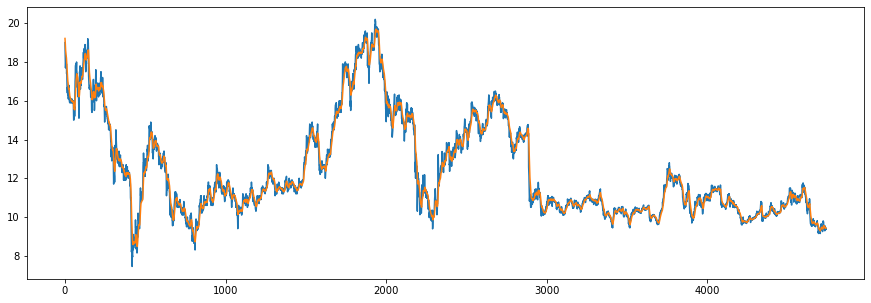

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/C6L.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]

    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [11]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4715, 25, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4715, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 4288, 1.0: 213, 0.0: 214})

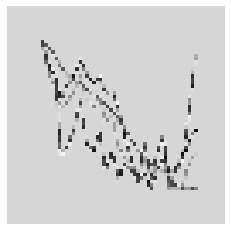

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('C6L.SI')]
    y = nr_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('C6L.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('C6L.SI')]
    y = r_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.352826510721248, 1: 7.396078431372549, 2: 0.3664626445156903}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2464 - accuracy: 0.3539 - mse: 1.6515 - weighted_accuracy: 0.3398 - weighted_mse: 1.7282 - val_loss: 0.2005 - val_accuracy: 0.0456 - val_mse: 0.8944 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.8944
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2050 - accuracy: 0.3616 - mse: 1.1518 - weighted_accuracy: 0.3278 - weighted_mse: 1.1675 - val_loss: 0.1901 - val_accuracy: 0.3733 - val_mse: 0.9975 - val_weighted_accuracy: 0.3733 - val_weighted_mse: 0.9975
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2049 - accuracy: 0.3396 - mse: 1.1597 - weighted_accuracy: 0.3440 - weighted_mse: 1.1719 - val_loss: 0.1948 - val_accuracy: 0.1198 - val_mse: 0.9429 - val_weighted_accuracy: 0.1198 - val_weighted_mse: 0.9429
Epoch 4/20
30/30 [==============================] - 0s 

7/7 [==============================] - 0s 7ms/step - loss: 0.2023 - accuracy: 0.0605 - mse: 0.9434 - weighted_accuracy: 0.0605 - weighted_mse: 0.9434
Test loss: 0.20233166217803955
Test accuracy: 0.060465116053819656


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 147
actual holds but predicted sell: 51
actual predicted holds: 0
Percentage buys correct: 5.031446540880503%
Percentage sells correct: 8.928571428571429%
Percentage holds correct: 0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 42.40506329113924%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought

<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1993 - accuracy: 0.3293 - mse: 1.1753 - weighted_accuracy: 0.3289 - weighted_mse: 1.1728 - val_loss: 0.1991 - val_accuracy: 0.0742 - val_mse: 1.0320 - val_weighted_accuracy: 0.0742 - val_weighted_mse: 1.0320
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2001 - accuracy: 0.2728 - mse: 1.1923 - weighted_accuracy: 0.3396 - weighted_mse: 1.1903 - val_loss: 0.2009 - val_accuracy: 0.0700 - val_mse: 1.0293 - val_weighted_accuracy: 0.0700 - val_weighted_mse: 1.0293
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1969 - accuracy: 0.2815 - mse: 1.1757 - weighted_accuracy: 0.3873 - weighted_mse: 1.1831 - val_loss: 0.2045 - val_accuracy: 0.0615 - val_mse: 0.9384 - val_weighted_accuracy: 0.0615 - val_weighted_mse: 0.9384
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1982 - accuracy: 0.2866 - mse: 1.1895 - weighted_accuracy: 0.3651 - weighted



Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2000 - accuracy: 0.0791 - mse: 0.9012 - weighted_accuracy: 0.0791 - weighted_mse: 0.9012


<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.20004381239414215
Test accuracy: 0.07906977087259293


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 109
actual holds but predicted sell: 85
actual predicted holds: 4
Percentage buys correct: 6.6115702479338845%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 42.5%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -0.6447409640047974%
Share price: $1.0025233714829802
Shares owned at the moment: 0
Cash capital at the moment: $99.08300630859716


Share price: $0.9894393161424171
Sh

Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1942 - accuracy: 0.2413 - mse: 1.2277 - weighted_accuracy: 0.4079 - weighted_mse: 1.1868 - val_loss: 0.1934 - val_accuracy: 0.0753 - val_mse: 1.0625 - val_weighted_accuracy: 0.0753 - val_weighted_mse: 1.0625
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1894 - accuracy: 0.2373 - mse: 1.2123 - weighted_accuracy: 0.4287 - weighted_mse: 1.2011 - val_loss: 0.1914 - val_accuracy: 0.0710 - val_mse: 1.0141 - val_weighted_accuracy: 0.0710 - val_weighted_mse: 1.0141
Epoch 6/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1911 - accuracy: 0.2431 - mse: 1.2268 - weighted_accuracy: 0.4197 - weighted_mse: 1.2045 - val_loss: 0.1992 - val_accuracy: 0.0732 - val_mse: 0.9530 - val_weighted_accuracy: 0.0732 - val_weighted_mse: 0.9530
Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1894 - accuracy: 0.2306 - mse: 1.2235 - weighted_accuracy: 0.4374 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1957 - accuracy: 0.0605 - mse: 1.0644 - weighted_accuracy: 0.0605 - weighted_mse: 1.0644    
Test loss: 0.1957084685564041
Test accuracy: 0.060465116053819656




<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 99
actual holds but predicted sell: 99
actual predicted holds: 0
Percentage buys correct: 6.422018348623853%
Percentage sells correct: 5.660377358490566%
Percentage holds correct: 0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 42.592592592592595%
Percentage high sells correct: 49.056603773584904%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -0.6447409640047974%
Share price: $1.0025233714829802
Shares owned at the moment: 0
Cash capital at the moment: $99.08300630859716


Share price: $0.9894393161424171
Shares owned at the moment: 99
Cash capital at the 

30/30 [==============================] - 0s 12ms/step - loss: 0.1821 - accuracy: 0.1591 - mse: 1.2586 - weighted_accuracy: 0.4968 - weighted_mse: 1.2140 - val_loss: 0.1912 - val_accuracy: 0.0732 - val_mse: 1.0621 - val_weighted_accuracy: 0.0732 - val_weighted_mse: 1.0621
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1780 - accuracy: 0.1580 - mse: 1.2670 - weighted_accuracy: 0.5354 - weighted_mse: 1.2408 - val_loss: 0.1920 - val_accuracy: 0.0764 - val_mse: 1.0709 - val_weighted_accuracy: 0.0764 - val_weighted_mse: 1.0709
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1756 - accuracy: 0.1628 - mse: 1.2726 - weighted_accuracy: 0.5557 - weighted_mse: 1.2564 - val_loss: 0.1934 - val_accuracy: 0.0742 - val_mse: 1.0243 - val_weighted_accuracy: 0.0742 - val_weighted_mse: 1.0243
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1818 - accuracy: 0.1418 - mse: 1.2310 - weighted_accuracy: 0.5072 - weighted_mse: 1.188

7/7 [==============================] - 0s 4ms/step - loss: 0.1987 - accuracy: 0.0744 - mse: 1.2270 - weighted_accuracy: 0.0744 - weighted_mse: 1.2270
Test loss: 0.19869057834148407
Test accuracy: 0.07441860437393188


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 104
actual holds but predicted sell: 89
actual predicted holds: 5
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 83.33333333333333%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 42.47787610619469%
Percentage high sells correct: 50.526315789473685%
Percentage mid holds correct: 50.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase fr

<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1653 - accuracy: 0.1405 - mse: 1.3391 - weighted_accuracy: 0.5699 - weighted_mse: 1.3001 - val_loss: 0.1950 - val_accuracy: 0.1315 - val_mse: 1.1518 - val_weighted_accuracy: 0.1315 - val_weighted_mse: 1.1518
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1614 - accuracy: 0.1524 - mse: 1.3567 - weighted_accuracy: 0.6096 - weighted_mse: 1.3134 - val_loss: 0.1946 - val_accuracy: 0.1495 - val_mse: 1.2122 - val_weighted_accuracy: 0.1495 - val_weighted_mse: 1.2122
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1599 - accuracy: 0.1434 - mse: 1.3571 - weighted_accuracy: 0.5950 - weighted_mse: 1.3372 - val_loss: 0.1965 - val_accuracy: 0.1029 - val_mse: 1.2139 - val_weighted_accuracy: 0.1029 - val_weighted_mse: 1.2139
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1619 - accuracy: 0.1564 - mse: 1.3443 - weighted_accuracy: 0.6054 - weighted

0           -64.1546  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.1953 - mse: 1.3628 - weighted_accuracy: 0.1953 - weighted_mse: 1.3628


<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1968073844909668
Test accuracy: 0.1953488439321518


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 105
actual holds but predicted sell: 62
actual predicted holds: 31
Percentage buys correct: 5.217391304347826%
Percentage sells correct: 7.462686567164179%
Percentage holds correct: 93.93939393939394%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 41.228070175438596%
Percentage high sells correct: 52.23880597014925%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -0.6447409640047974%
Share price: $1.0025233714829802
Shares owned at the moment: 0
Cash capital at the moment: $99.08

Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1394 - accuracy: 0.2473 - mse: 1.6383 - weighted_accuracy: 0.6759 - weighted_mse: 1.7280 - val_loss: 0.1924 - val_accuracy: 0.2683 - val_mse: 1.3863 - val_weighted_accuracy: 0.2683 - val_weighted_mse: 1.3863
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1346 - accuracy: 0.2614 - mse: 1.6816 - weighted_accuracy: 0.7033 - weighted_mse: 1.7846 - val_loss: 0.1937 - val_accuracy: 0.2439 - val_mse: 1.3773 - val_weighted_accuracy: 0.2439 - val_weighted_mse: 1.3773
Epoch 10/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1377 - accuracy: 0.2625 - mse: 1.7016 - weighted_accuracy: 0.6851 - weighted_mse: 1.7798 - val_loss: 0.1910 - val_accuracy: 0.2800 - val_mse: 1.4218 - val_weighted_accuracy: 0.2800 - val_weighted_mse: 1.4218
Epoch 11/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1352 - accuracy: 0.2853 - mse: 1.6914 - weighted_accuracy: 0.6953 - weight

7/7 [==============================] - 0s 3ms/step - loss: 0.1876 - accuracy: 0.3814 - mse: 1.6858 - weighted_accuracy: 0.3814 - weighted_mse: 1.6858
Test loss: 0.18759994208812714
Test accuracy: 0.3813953399658203




<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 50
actual predicted holds: 74
Percentage buys correct: 4.938271604938271%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 92.5%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 41.25%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 86.25%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -0.6447409640047974%
Share price: $1.0025233714829802
Shares owned at the moment: 0
Cash capital at the moment: $99.08300630859716


Share price: $0.9894393161424171
Shares owned at the moment: 99
Cash capital at the moment

30/30 [==============================] - 0s 14ms/step - loss: 0.1219 - accuracy: 0.3990 - mse: 2.0005 - weighted_accuracy: 0.7500 - weighted_mse: 2.3012 - val_loss: 0.1783 - val_accuracy: 0.4899 - val_mse: 1.6824 - val_weighted_accuracy: 0.4899 - val_weighted_mse: 1.6824
Epoch 9/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1239 - accuracy: 0.4096 - mse: 1.9217 - weighted_accuracy: 0.7409 - weighted_mse: 2.2515 - val_loss: 0.1762 - val_accuracy: 0.4730 - val_mse: 1.7737 - val_weighted_accuracy: 0.4730 - val_weighted_mse: 1.7737
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1230 - accuracy: 0.4260 - mse: 1.9588 - weighted_accuracy: 0.7395 - weighted_mse: 2.2935 - val_loss: 0.1759 - val_accuracy: 0.4655 - val_mse: 1.5980 - val_weighted_accuracy: 0.4655 - val_weighted_mse: 1.5980
Epoch 11/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1197 - accuracy: 0.4385 - mse: 1.9837 - weighted_accuracy: 0.7552 - weighted_mse: 2.3

7/7 [==============================] - 0s 3ms/step - loss: 0.1786 - accuracy: 0.4930 - mse: 2.0499 - weighted_accuracy: 0.4930 - weighted_mse: 2.0499
Test loss: 0.17858755588531494
Test accuracy: 0.49302324652671814




<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 3
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 65
actual holds but predicted sell: 30
actual predicted holds: 103
Percentage buys correct: 2.857142857142857%
Percentage sells correct: 3.225806451612903%
Percentage holds correct: 90.35087719298245%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.927536231884055%
Percentage high sells correct: 51.61290322580645%
Percentage mid holds correct: 85.08771929824562%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: 0.09623164985612664%
Share price: $1.01
Shares owned at the moment: 0
Cash capital at the moment: $99.82115701966835


Share price: $0.9931775412724846
Shares owned at the moment: 100


30/30 [==============================] - 1s 17ms/step - loss: 0.1072 - accuracy: 0.6039 - mse: 2.4254 - weighted_accuracy: 0.8046 - weighted_mse: 3.2902 - val_loss: 0.1509 - val_accuracy: 0.6681 - val_mse: 2.0759 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 2.0759
Epoch 16/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1047 - accuracy: 0.6185 - mse: 2.5285 - weighted_accuracy: 0.8063 - weighted_mse: 3.4387 - val_loss: 0.1544 - val_accuracy: 0.6448 - val_mse: 2.1613 - val_weighted_accuracy: 0.6448 - val_weighted_mse: 2.1613
Epoch 17/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1043 - accuracy: 0.6132 - mse: 2.5407 - weighted_accuracy: 0.8080 - weighted_mse: 3.4295 - val_loss: 0.1484 - val_accuracy: 0.6861 - val_mse: 2.1103 - val_weighted_accuracy: 0.6861 - val_weighted_mse: 2.1103
Epoch 18/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1055 - accuracy: 0.6190 - mse: 2.5228 - weighted_accuracy: 0.8046 - weighted_mse: 3.

<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 3
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 50
actual holds but predicted sell: 21
actual predicted holds: 127
Percentage buys correct: 0.0%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 90.71428571428571%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 44.23076923076923%
Percentage high sells correct: 59.09090909090909%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: 0.09623164985612664%
Share price: $1.01
Shares owned at the moment: 0
Cash capital at the moment: $99.82115701966835


Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: 

30/30 [==============================] - 0s 13ms/step - loss: 0.0922 - accuracy: 0.6866 - mse: 3.1472 - weighted_accuracy: 0.8424 - weighted_mse: 4.7180 - val_loss: 0.1306 - val_accuracy: 0.7656 - val_mse: 2.6394 - val_weighted_accuracy: 0.7656 - val_weighted_mse: 2.6394
Epoch 16/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0917 - accuracy: 0.6978 - mse: 3.2000 - weighted_accuracy: 0.8464 - weighted_mse: 4.6586 - val_loss: 0.1370 - val_accuracy: 0.7243 - val_mse: 2.5158 - val_weighted_accuracy: 0.7243 - val_weighted_mse: 2.5158
Epoch 17/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0916 - accuracy: 0.7028 - mse: 3.2249 - weighted_accuracy: 0.8335 - weighted_mse: 4.9701 - val_loss: 0.1358 - val_accuracy: 0.7275 - val_mse: 2.3833 - val_weighted_accuracy: 0.7275 - val_weighted_mse: 2.3833
Epoch 18/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0907 - accuracy: 0.7039 - mse: 3.2272 - weighted_accuracy: 0.8394 - weighted_mse: 5.

<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 37
actual holds but predicted sell: 14
actual predicted holds: 147
Percentage buys correct: 0.0%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 90.74074074074075%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 59.45945945945946%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 84.5679012345679%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: 0.09623164985612664%
Share price: $1.01
Shares owned at the moment: 0
Cash capital at the moment: $99.82115701966835


Share price: $0.9464485684768917
Shares owned at the moment: 105
Cash capital at the moment: $

30/30 [==============================] - 0s 12ms/step - loss: 0.0797 - accuracy: 0.7731 - mse: 4.2700 - weighted_accuracy: 0.8778 - weighted_mse: 6.7806 - val_loss: 0.1222 - val_accuracy: 0.7847 - val_mse: 3.2572 - val_weighted_accuracy: 0.7847 - val_weighted_mse: 3.2572
Epoch 18/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0767 - accuracy: 0.7800 - mse: 4.3055 - weighted_accuracy: 0.8711 - weighted_mse: 6.8219 - val_loss: 0.1207 - val_accuracy: 0.8038 - val_mse: 3.0768 - val_weighted_accuracy: 0.8038 - val_weighted_mse: 3.0768
Epoch 19/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0762 - accuracy: 0.7739 - mse: 4.2341 - weighted_accuracy: 0.8837 - weighted_mse: 6.8019 - val_loss: 0.1174 - val_accuracy: 0.8081 - val_mse: 3.4929 - val_weighted_accuracy: 0.8081 - val_weighted_mse: 3.4929
Epoch 20/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0794 - accuracy: 0.7731 - mse: 4.3220 - weighted_accuracy: 0.8741 - weighted_mse: 6.

<ipython-input-21-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-21-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-21-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 28
actual holds but predicted sell: 9
actual predicted holds: 161
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 90.96045197740114%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 64.28571428571429%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 84.7457627118644%


Capital: 100
Share price: $0.9464485684768917
Shares owned at the moment: 105
Cash capital at the moment: $0.34961328577865913


Price increase from previously bought: -36.119185310227174%
Share price: $0.6062617035671785
Shares owned at the moment: 0
Cash capital at the moment: $63.832034093427374


Share price: $0.4305607551603361
Shares owned at the moment: 147
Cash capital at

In [22]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.060465,5.031447,8.928571,0.000000,42.405063,57.142857,0.000000,70.326041,-78.238355
1,0.079070,6.611570,5.555556,100.000000,42.500000,50.000000,75.000000,12.847867,-78.238355
2,0.060465,6.422018,5.660377,0.000000,42.592593,49.056604,0.000000,-71.230288,-78.238355
3,0.074419,5.263158,5.263158,83.333333,42.477876,50.526316,50.000000,-82.032828,-78.238355
4,0.195349,5.217391,7.462687,93.939394,41.228070,52.238806,87.878788,-93.106457,-78.238355
5,0.381395,4.938272,7.407407,92.500000,41.250000,55.555556,86.250000,-66.183959,-78.238355
6,0.493023,2.857143,3.225806,90.350877,44.927536,51.612903,85.087719,-76.565692,-78.238355
7,0.595349,0.000000,4.545455,90.714286,44.230769,59.090909,85.000000,-49.165790,-78.238355
8,0.688372,0.000000,6.666667,90.740741,59.459459,60.000000,84.567901,-55.793409,-78.238355
9,0.748837,0.000000,0.000000,90.960452,64.285714,66.666667,84.745763,-12.716083,-78.238355


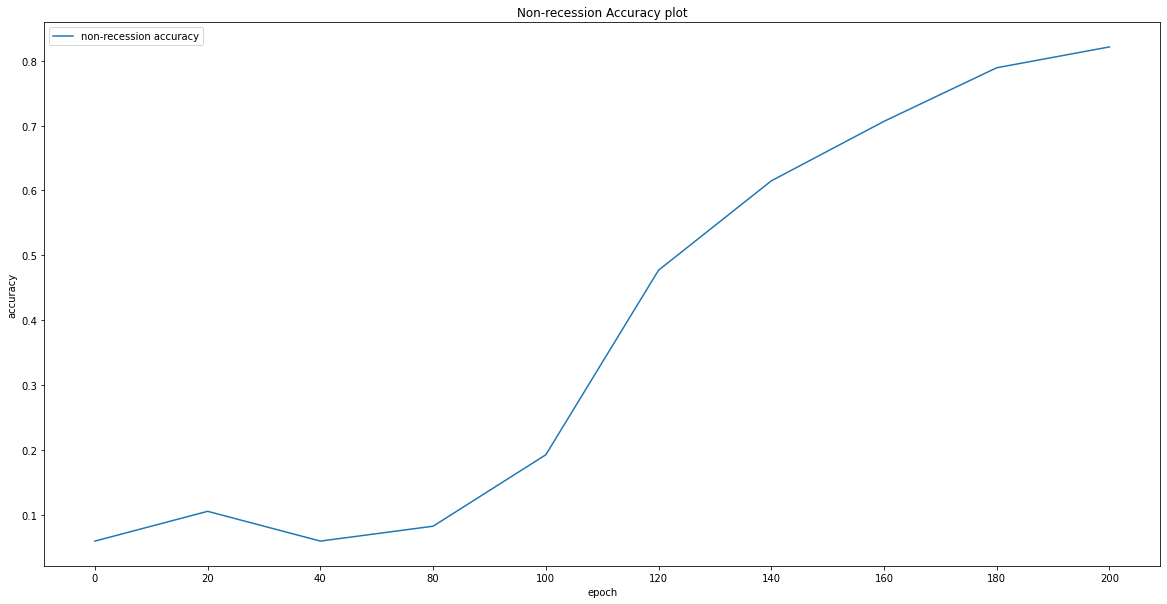

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

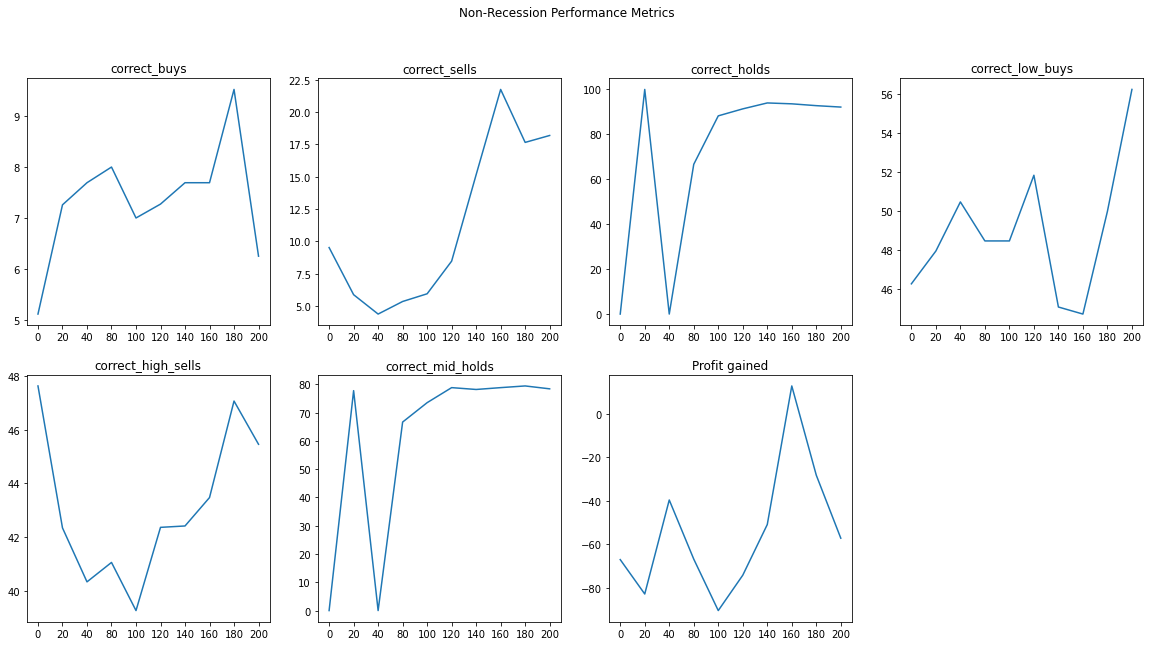

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

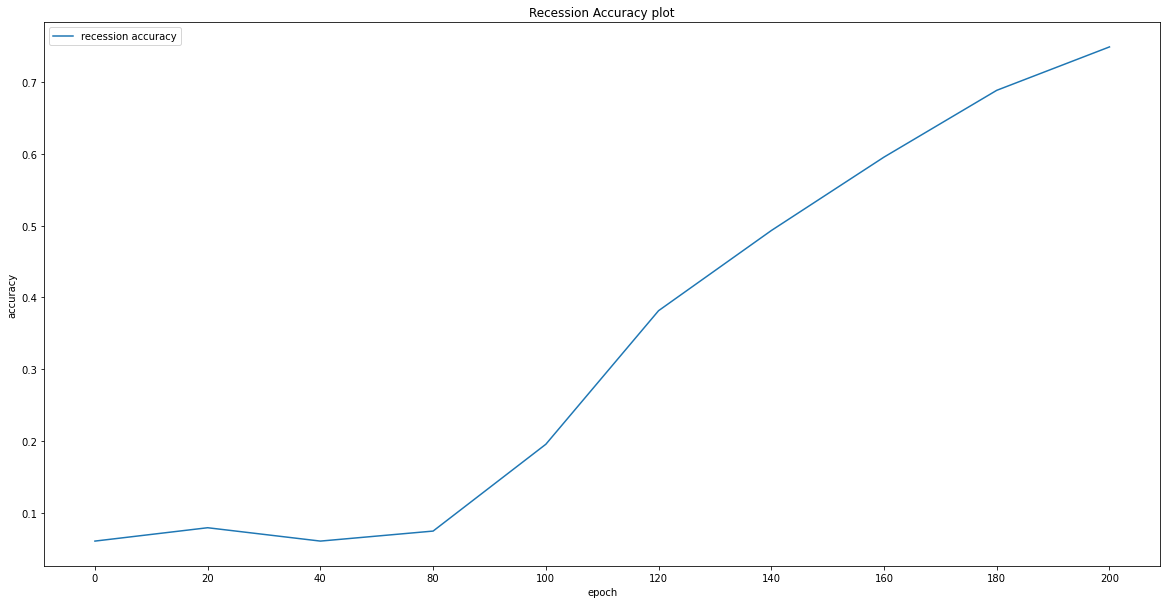

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

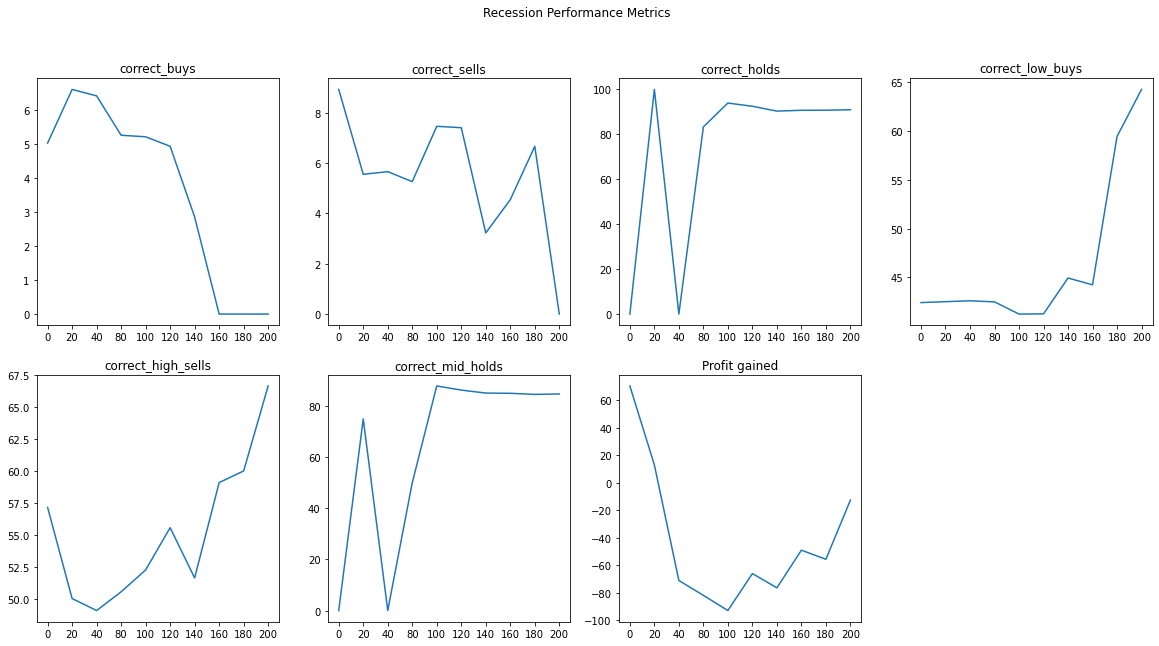

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### OCBC Bank

In [27]:
nr_test_sets = ['O39.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-07        11.31  11.282011 -31.958699  451430629.0     2.0
2018-12-10        11.23  11.274010 -40.206210  447140929.0     2.0
2018-12-11        11.07  11.242623 -56.701035  443372229.0     1.0
2018-12-12        11.05  11.212989 -65.517215  438680229.0     2.0
2018-12-13        11.20  11.210991 -48.275877  443121729.0     2.0


In [28]:
r_test_sets = ['O39.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-12-09        10.71  10.802927 -75.438564  46900142.0     2.0
2019-12-10        10.64  10.777861 -87.272614  42802742.0     1.0
2019-12-11        10.62  10.753575 -90.196045  37577242.0     2.0
2019-12-12        10.68  10.742256 -78.431263  41151442.0     2.0
2019-12-13        10.85  10.758832 -45.097929  47717842.0     2.0


### training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


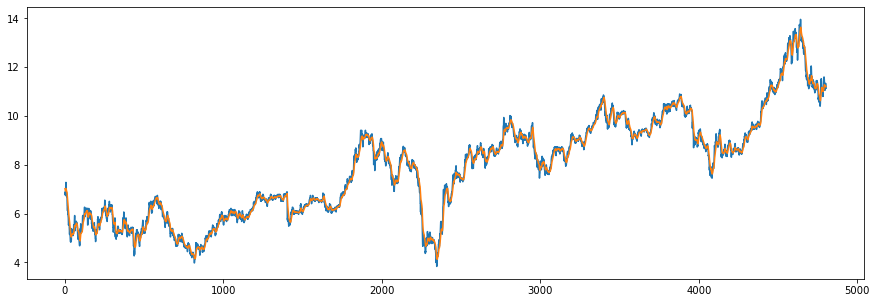

(4779, 64, 64, 1)

In [29]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/O39.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]

    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

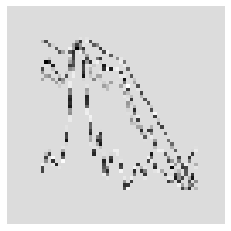

In [30]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [31]:
X = X/255

In [32]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [33]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [34]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [57]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('O39.SI')]
    y = nr_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('O39.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('O39.SI')]
    y = r_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.240530303030303, 1: 7.915113871635611, 2: 0.36555746796710653}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 46ms/step - loss: 0.2345 - accuracy: 0.4538 - mse: 1.5666 - weighted_accuracy: 0.3611 - weighted_mse: 1.5990 - val_loss: 0.2141 - val_accuracy: 0.0439 - val_mse: 1.0033 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 1.0033
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2109 - accuracy: 0.2446 - mse: 1.2058 - weighted_accuracy: 0.3206 - weighted_mse: 1.2051 - val_loss: 0.1989 - val_accuracy: 0.0492 - val_mse: 0.9848 - val_weighted_accuracy: 0.0492 - val_weighted_mse: 0.9848
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2096 - accuracy: 0.2231 - mse: 1.1774 - weighted_accuracy: 0.3208 - weighted_mse: 1.1672 - val_loss: 0.2031 - val_accuracy: 0.0481 - val_mse: 1.0909 - val_weighted_accuracy: 0.0481 - val_weighted_mse: 1.0909
Epoch 4/20
30/30 [==============================] - 1s

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 111
actual holds but predicted sell: 89
actual predicted holds: 1
Percentage buys correct: 5.737704918032787%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 45.08196721311475%
Percentage high sells correct: 47.87234042553192%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.709386079515369
Shares owned at the moment: 140
Cash capital at the moment: $0.41283522723492183


Price increase from previously bought: -11.486103629088685%
Share price: $0.629631998754957
Shares owned at the moment: 0
Cash capital at the moment: $88.31890673340824


Share price: $0.5498773329183202
Shares owned at the moment: 160
Cash capital

<ipython-input-57-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 28ms/step - loss: 0.2002 - accuracy: 0.4183 - mse: 1.1419 - weighted_accuracy: 0.3816 - weighted_mse: 1.1424 - val_loss: 0.1968 - val_accuracy: 0.0837 - val_mse: 1.1085 - val_weighted_accuracy: 0.0837 - val_weighted_mse: 1.1085
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2013 - accuracy: 0.3618 - mse: 1.1852 - weighted_accuracy: 0.3673 - weighted_mse: 1.1634 - val_loss: 0.1935 - val_accuracy: 0.3661 - val_mse: 0.9299 - val_weighted_accuracy: 0.3661 - val_weighted_mse: 0.9299
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1992 - accuracy: 0.3223 - mse: 1.1421 - weighted_accuracy: 0.3670 - weighted_mse: 1.1370 - val_loss: 0.1917 - val_accuracy: 0.2615 - val_mse: 1.0564 - val_weighted_accuracy: 0.2615 - val_weighted_mse: 1.0564
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1981 - accuracy: 0.3570 - mse: 1.1642 - weighted_accuracy: 0.4279 - weighted

1/7 [===>..........................] - ETA: 0s - loss: 0.1954 - accuracy: 0.2500 - mse: 0.9909 - weighted_accuracy: 0.2500 - weighted_mse: 0.9909

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 8ms/step - loss: 0.1969 - accuracy: 0.2326 - mse: 0.9940 - weighted_accuracy: 0.2326 - weighted_mse: 0.9940
Test loss: 0.1969374567270279
Test accuracy: 0.23255814611911774


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 5
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 66
actual holds but predicted sell: 88
actual predicted holds: 39
Percentage buys correct: 5.47945205479452%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 88.63636363636364%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.054794520547944%
Percentage high sells correct: 47.422680412371136%
Percentage mid holds correct: 84.0909090909091%


Capital: 100
Share price: $0.8606098354344935
Shares owned at the moment: 115
Cash capital at the moment: $0.757701064577077


Price i

<ipython-input-57-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1840 - accuracy: 0.2404 - mse: 1.2577 - weighted_accuracy: 0.5006 - weighted_mse: 1.2174 - val_loss: 0.2041 - val_accuracy: 0.1527 - val_mse: 0.9934 - val_weighted_accuracy: 0.1527 - val_weighted_mse: 0.9934
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1835 - accuracy: 0.2357 - mse: 1.2906 - weighted_accuracy: 0.4816 - weighted_mse: 1.2736 - val_loss: 0.1943 - val_accuracy: 0.2364 - val_mse: 0.9891 - val_weighted_accuracy: 0.2364 - val_weighted_mse: 0.9891
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1850 - accuracy: 0.2671 - mse: 1.2235 - weighted_accuracy: 0.4963 - weighted_mse: 1.1922 - val_loss: 0.2001 - val_accuracy: 0.1004 - val_mse: 1.1216 - val_weighted_accuracy: 0.1004 - val_weighted_mse: 1.1216
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1804 - accuracy: 0.2890 - mse: 1.2767 - weighted_accuracy: 0.5295 - weighted



Recession Test


1/7 [===>..........................] - ETA: 0s - loss: 0.1938 - accuracy: 0.2188 - mse: 1.2067 - weighted_accuracy: 0.2188 - weighted_mse: 1.2067

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 7ms/step - loss: 0.1939 - accuracy: 0.2605 - mse: 1.2217 - weighted_accuracy: 0.2605 - weighted_mse: 1.2217
Test loss: 0.19394657015800476
Test accuracy: 0.2604651153087616


number of predictions: 215
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 89
actual holds but predicted sell: 61
actual predicted holds: 43
Percentage buys correct: 9.0%
Percentage sells correct: 5.970149253731344%
Percentage holds correct: 89.58333333333333%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.74626865671642%
Percentage mid holds correct: 80.85106382978724%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bo

<ipython-input-57-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r




RUNNING EPOCHS 60 - 80



Epoch 1/20
30/30 [==============================] - 1s 30ms/step - loss: 0.1671 - accuracy: 0.2809 - mse: 1.3531 - weighted_accuracy: 0.5982 - weighted_mse: 1.2952 - val_loss: 0.1973 - val_accuracy: 0.2082 - val_mse: 1.1715 - val_weighted_accuracy: 0.2082 - val_weighted_mse: 1.1715
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1679 - accuracy: 0.2833 - mse: 1.3449 - weighted_accuracy: 0.5841 - weighted_mse: 1.3032 - val_loss: 0.1977 - val_accuracy: 0.1935 - val_mse: 1.1616 - val_weighted_accuracy: 0.1935 - val_weighted_mse: 1.1616
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1677 - accuracy: 0.2833 - mse: 1.3641 - weighted_accuracy: 0.5940 - weighted_mse: 1.3158 - val_loss: 0.1882 - val_accuracy: 0.2762 - val_mse: 1.1914 - val_weighted_accuracy: 0.2762 - val_weighted_mse: 1.1914
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1671 - accuracy: 0.2817 - mse: 1.3567 - weighte



Recession Test


1/7 [===>..........................] - ETA: 0s - loss: 0.1964 - accuracy: 0.2812 - mse: 1.2898 - weighted_accuracy: 0.2812 - weighted_mse: 1.289

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 5ms/step - loss: 0.1916 - accuracy: 0.3535 - mse: 1.3069 - weighted_accuracy: 0.3535 - weighted_mse: 1.3069
Test loss: 0.19157005846500397
Test accuracy: 0.35348838567733765


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 80
actual holds but predicted sell: 47
actual predicted holds: 66
Percentage buys correct: 7.777777777777778%
Percentage sells correct: 5.660377358490566%
Percentage holds correct: 91.66666666666667%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.888888888888886%
Percentage high sells correct: 47.16981132075472%
Percentage mid holds correct: 84.50704225352112%


Capital: 100
Share price: $0.9978048904590266
Shares owned at the moment: 99
Cash capital at the moment: $0.9456634631288949


Price

<ipython-input-57-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1475 - accuracy: 0.3895 - mse: 1.4671 - weighted_accuracy: 0.6704 - weighted_mse: 1.4609 - val_loss: 0.1856 - val_accuracy: 0.3556 - val_mse: 1.3136 - val_weighted_accuracy: 0.3556 - val_weighted_mse: 1.3136
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1444 - accuracy: 0.3908 - mse: 1.5615 - weighted_accuracy: 0.6871 - weighted_mse: 1.5807 - val_loss: 0.1743 - val_accuracy: 0.4561 - val_mse: 1.2897 - val_weighted_accuracy: 0.4561 - val_weighted_mse: 1.2897
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1449 - accuracy: 0.3892 - mse: 1.5299 - weighted_accuracy: 0.6928 - weighted_mse: 1.4981 - val_loss: 0.1715 - val_accuracy: 0.4686 - val_mse: 1.4185 - val_weighted_accuracy: 0.4686 - val_weighted_mse: 1.4185
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1472 - accuracy: 0.4201 - mse: 1.5416 - weighted_accuracy: 0.6640 - weighted



Recession Test


1/7 [===>..........................] - ETA: 0s - loss: 0.1827 - accuracy: 0.5000 - mse: 1.4675 - weighted_accuracy: 0.5000 - weighted_mse: 1.4675

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 6ms/step - loss: 0.1765 - accuracy: 0.5023 - mse: 1.4531 - weighted_accuracy: 0.5023 - weighted_mse: 1.4531
Test loss: 0.17650964856147766
Test accuracy: 0.5023255944252014


number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 56
actual holds but predicted sell: 37
actual predicted holds: 100
Percentage buys correct: 7.8125%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 91.74311926605505%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 56.25%
Percentage high sells correct: 47.61904761904762%
Percentage mid holds correct: 87.03703703703704%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previous

<ipython-input-57-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1246 - accuracy: 0.5200 - mse: 1.6529 - weighted_accuracy: 0.7551 - weighted_mse: 1.7945 - val_loss: 0.1622 - val_accuracy: 0.5418 - val_mse: 1.4240 - val_weighted_accuracy: 0.5418 - val_weighted_mse: 1.4240
Epoch 2/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1220 - accuracy: 0.5399 - mse: 1.6791 - weighted_accuracy: 0.7604 - weighted_mse: 1.8311 - val_loss: 0.1549 - val_accuracy: 0.6140 - val_mse: 1.4015 - val_weighted_accuracy: 0.6140 - val_weighted_mse: 1.4015
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1244 - accuracy: 0.5456 - mse: 1.6575 - weighted_accuracy: 0.7688 - weighted_mse: 1.7823 - val_loss: 0.1867 - val_accuracy: 0.4017 - val_mse: 1.4439 - val_weighted_accuracy: 0.4017 - val_weighted_mse: 1.4439
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1259 - accuracy: 0.5161 - mse: 1.6816 - weighted_accuracy: 0.7383 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1514 - accuracy: 0.6419 - mse: 1.5611 - weighted_accuracy: 0.6419 - weighted_mse: 1.5611


<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1513754427433014
Test accuracy: 0.6418604850769043


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 32
actual holds but predicted sell: 26
actual predicted holds: 135
Percentage buys correct: 3.0303030303030303%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 88.8157894736842%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 57.57575757575758%
Percentage high sells correct: 46.666666666666664%
Percentage mid holds correct: 84.76821192052981%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Price increase from previously bought: -98.83295098971836%
Share price: $0.01
Shares owned at the moment: 0
Cash capital at the moment: $1.7608129355706905

Epoch 17/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0893 - accuracy: 0.7159 - mse: 1.9916 - weighted_accuracy: 0.8399 - weighted_mse: 2.5141 - val_loss: 0.1291 - val_accuracy: 0.7385 - val_mse: 1.4417 - val_weighted_accuracy: 0.7385 - val_weighted_mse: 1.4417
Epoch 18/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0925 - accuracy: 0.7078 - mse: 2.0115 - weighted_accuracy: 0.8260 - weighted_mse: 2.4777 - val_loss: 0.1367 - val_accuracy: 0.6935 - val_mse: 1.7517 - val_weighted_accuracy: 0.6935 - val_weighted_mse: 1.7517
Epoch 19/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0890 - accuracy: 0.7110 - mse: 2.1084 - weighted_accuracy: 0.8194 - weighted_mse: 2.6061 - val_loss: 0.1319 - val_accuracy: 0.7103 - val_mse: 1.6572 - val_weighted_accuracy: 0.7103 - val_weighted_mse: 1.6572
Epoch 20/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0833 - accuracy: 0.7290 - mse: 2.1355 - weighted_accuracy: 0.8517 - weig

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1263461410999298
Test accuracy: 0.7488372325897217


number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 19
actual holds but predicted sell: 15
actual predicted holds: 159
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 89.32584269662921%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 85.87570621468926%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Price increase from previously bought: -98.83295098971836%
Share price: $0.01
Shares owned at the moment: 0
Cash capital at the moment: $1.7608129355706905


Share price

Epoch 18/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0708 - accuracy: 0.7709 - mse: 2.4710 - weighted_accuracy: 0.8736 - weighted_mse: 3.2290 - val_loss: 0.1206 - val_accuracy: 0.7782 - val_mse: 1.9755 - val_weighted_accuracy: 0.7782 - val_weighted_mse: 1.9755
Epoch 19/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0710 - accuracy: 0.7787 - mse: 2.5844 - weighted_accuracy: 0.8806 - weighted_mse: 3.2874 - val_loss: 0.1162 - val_accuracy: 0.8002 - val_mse: 1.9988 - val_weighted_accuracy: 0.8002 - val_weighted_mse: 1.9988
Epoch 20/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0732 - accuracy: 0.7701 - mse: 2.5171 - weighted_accuracy: 0.8610 - weighted_mse: 3.2156 - val_loss: 0.1160 - val_accuracy: 0.7971 - val_mse: 1.9011 - val_weighted_accuracy: 0.7971 - val_weighted_mse: 1.9011
Validation loss: 0.116033636033535
Validation accuracy: 0.7970711588859558


Non-Recession Test


7/7 [==============================] - 0s 3ms/step

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.12241636216640472
Test accuracy: 0.7767441868782043


number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 16
actual holds but predicted sell: 12
actual predicted holds: 165
Percentage buys correct: 0.0%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 89.67391304347827%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 62.5%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 86.33879781420765%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Price increase from previously bought: -98.83295098971836%
Share price: $0.01
Shares owned at the moment: 0
Cash capital at the moment: $1.7608129355706905


Share price: $0.29048

30/30 [==============================] - 0s 16ms/step - loss: 0.0621 - accuracy: 0.8088 - mse: 2.9779 - weighted_accuracy: 0.8938 - weighted_mse: 3.7060 - val_loss: 0.1081 - val_accuracy: 0.8368 - val_mse: 2.2978 - val_weighted_accuracy: 0.8368 - val_weighted_mse: 2.2978
Epoch 19/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0628 - accuracy: 0.8172 - mse: 3.0364 - weighted_accuracy: 0.8915 - weighted_mse: 3.8109 - val_loss: 0.1072 - val_accuracy: 0.8483 - val_mse: 2.3336 - val_weighted_accuracy: 0.8483 - val_weighted_mse: 2.3336
Epoch 20/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0587 - accuracy: 0.8242 - mse: 3.1588 - weighted_accuracy: 0.9018 - weighted_mse: 4.0006 - val_loss: 0.1054 - val_accuracy: 0.8556 - val_mse: 2.4449 - val_weighted_accuracy: 0.8556 - val_weighted_mse: 2.4449
Validation loss: 0.10539112240076065
Validation accuracy: 0.8556485176086426


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.11692140251398087
Test accuracy: 0.8511627912521362


number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 6
actual holds but predicted sell: 5
actual predicted holds: 182
Percentage buys correct: 0.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 89.65517241379311%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.63366336633663%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Price increase from previously bought: -63.252173790860375%
Share price: $0.3148781746558449
Shares owned at the moment: 0
Cash capital at the moment: $37.02942505793348


Share pric

7/7 [==============================] - 0s 3ms/step - loss: 0.1241 - accuracy: 0.8465 - mse: 2.9647 - weighted_accuracy: 0.8465 - weighted_mse: 2.9647
Test loss: 0.12409843504428864
Test accuracy: 0.8465116024017334


number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 7
actual holds but predicted sell: 5
actual predicted holds: 181
Percentage buys correct: 0.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 89.60396039603961%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 71.42857142857143%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.56716417910448%


Capital: 100
Share price: $0.8545121352868346
Shares owned at the moment: 116
Cash capital at the moment: $0.6040029355706906


Price increase from previously b

<ipython-input-57-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-57-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-57-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [58]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.083721,7.812500,5.952381,100.000000,49.606299,47.619048,100.000000,-3.427226,-24.56292
1,0.232558,5.479452,7.142857,88.636364,52.054795,47.422680,84.090909,-21.497370,-24.56292
2,0.260465,9.000000,5.970149,89.583333,50.000000,50.746269,80.851064,1759.470202,-24.56292
3,0.353488,7.777778,5.660377,91.666667,48.888889,47.169811,84.507042,-37.119047,-24.56292
4,0.502326,7.812500,7.142857,91.743119,56.250000,47.619048,87.037037,-96.916104,-24.56292
5,0.641860,3.030303,6.666667,88.815789,57.575758,46.666667,84.768212,-94.587567,-24.56292
6,0.748837,0.000000,11.111111,89.325843,57.894737,44.444444,85.875706,-92.301945,-24.56292
7,0.776744,0.000000,13.333333,89.673913,62.500000,33.333333,86.338798,-92.065385,-24.56292
8,0.851163,0.000000,16.666667,89.655172,66.666667,50.000000,86.633663,43.203394,-24.56292
9,0.846512,0.000000,16.666667,89.603960,71.428571,50.000000,86.567164,54.194410,-24.56292


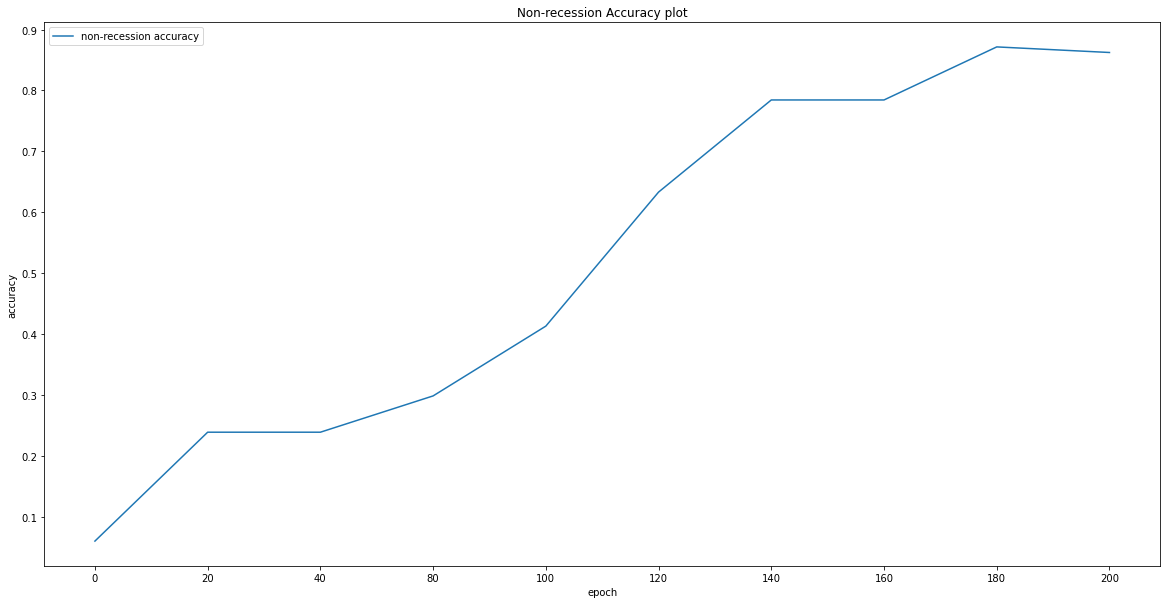

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

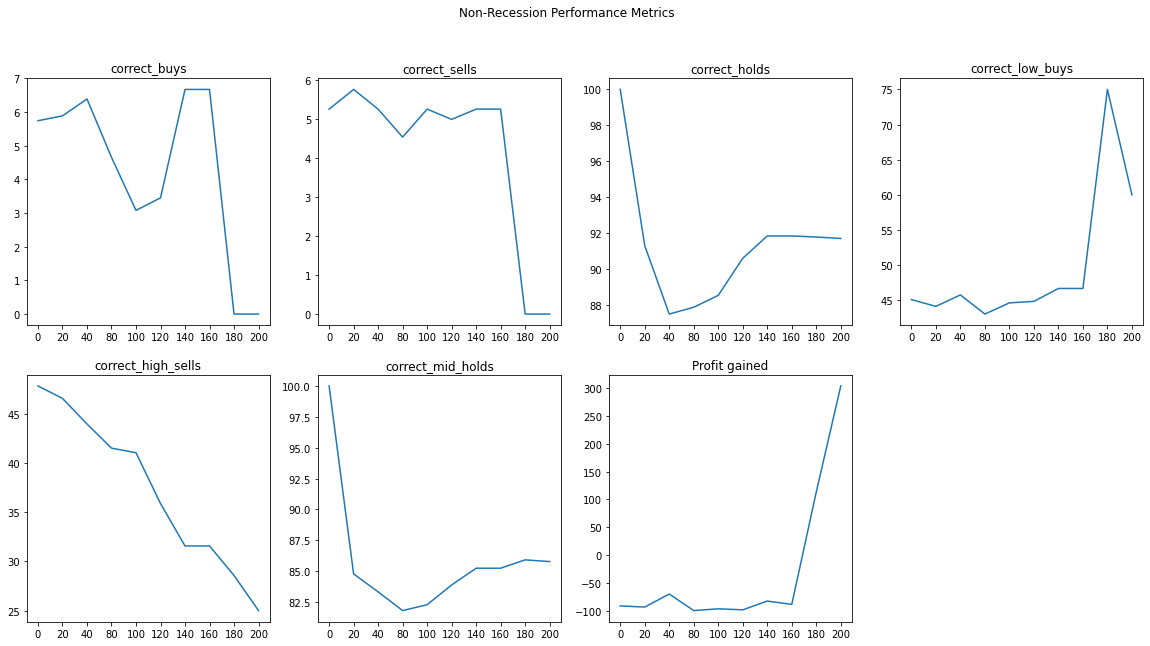

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

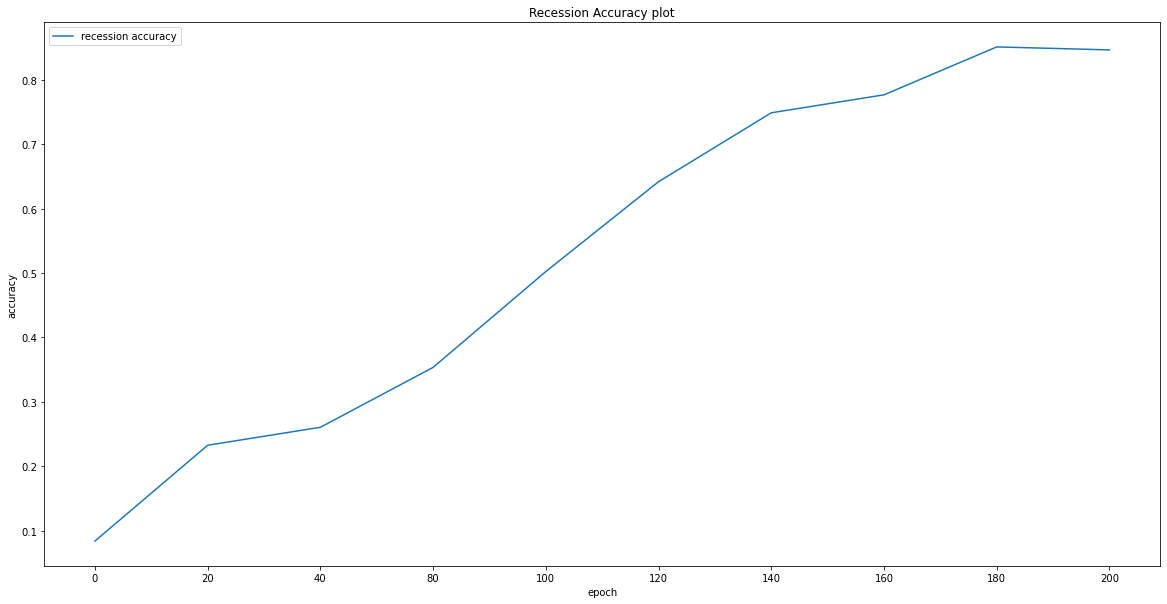

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

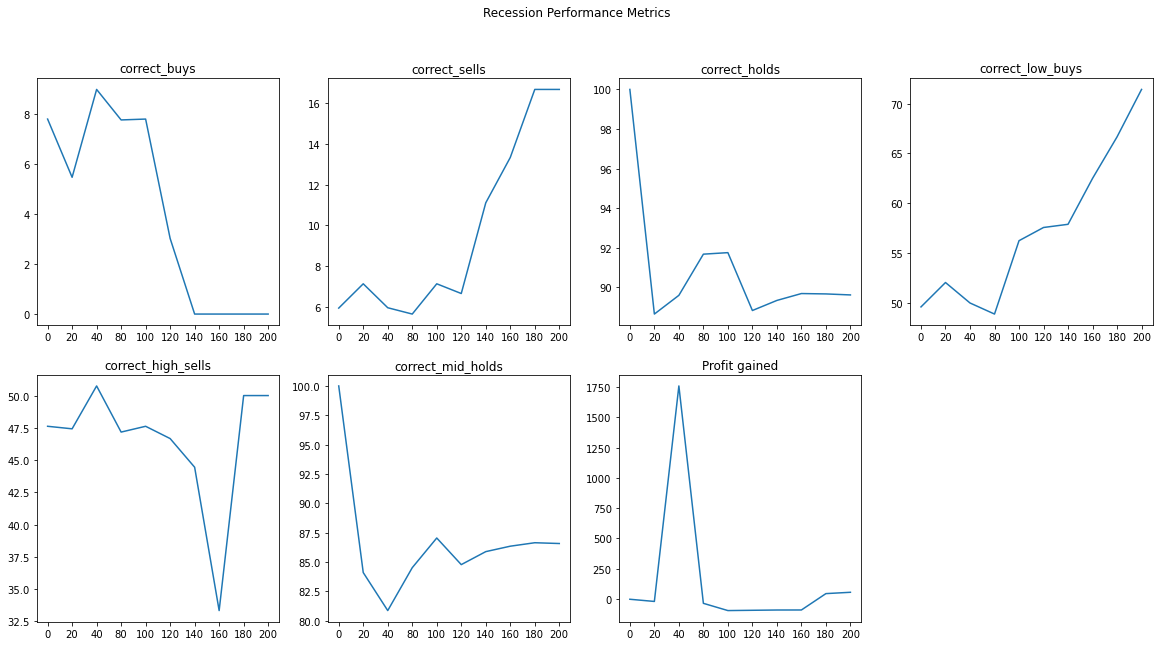

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### CNOOC Limited

In [63]:
nr_test_sets = ['0883.HK']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-05        13.84  13.206983 -13.953473  9.687209e+09     2.0
2018-12-06        13.32  13.224370 -44.186053  9.629185e+09     2.0
2018-12-07        13.06  13.199082 -59.302288  9.569866e+09     2.0
2018-12-10        12.78  13.134608 -75.581395  9.417195e+09     2.0
2018-12-11        12.82  13.086207 -73.255816  9.502415e+09     2.0


In [64]:
r_test_sets = ['0883.HK']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-12-05        11.16  11.619972 -96.000004 -309527686.0     2.0
2019-12-06        11.30  11.570745 -81.249969 -265649189.0     2.0
2019-12-09        11.30  11.529092 -81.249969 -265649189.0     2.0
2019-12-10        11.32  11.496924 -79.166687 -219481840.0     2.0
2019-12-11        11.28  11.463551 -83.333350 -262942881.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


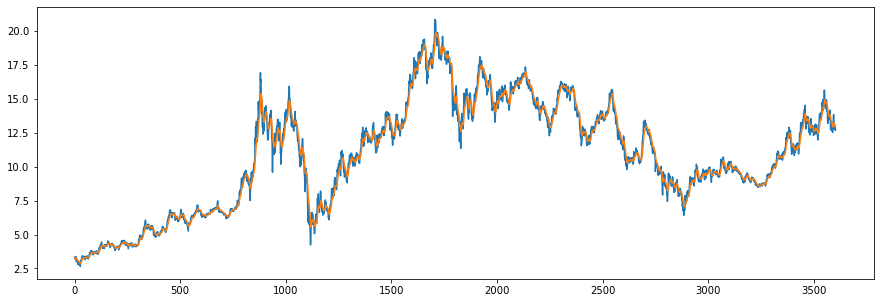

(3580, 64, 64, 1)

In [65]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/0883.HK_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]

    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

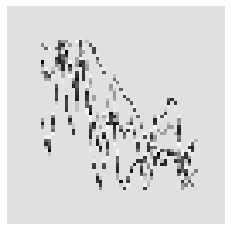

In [66]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [67]:
X = X/255

In [68]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [69]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [70]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [78]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('0883.HK')]
    y = nr_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('0883.HK'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('0883.HK')]
    y = r_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.232323232323233, 1: 7.343589743589743, 2: 0.3668972585190879}



RUNNING EPOCHS 0 - 20



Epoch 1/20
23/23 [==============================] - 0s 20ms/step - loss: 0.2592 - accuracy: 0.4860 - mse: 1.7227 - weighted_accuracy: 0.3258 - weighted_mse: 1.7895 - val_loss: 0.1872 - val_accuracy: 0.8492 - val_mse: 0.8309 - val_weighted_accuracy: 0.8492 - val_weighted_mse: 0.8309
Epoch 2/20
23/23 [==============================] - 0s 11ms/step - loss: 0.2073 - accuracy: 0.4162 - mse: 1.2066 - weighted_accuracy: 0.3442 - weighted_mse: 1.2276 - val_loss: 0.1981 - val_accuracy: 0.0447 - val_mse: 1.0124 - val_weighted_accuracy: 0.0447 - val_weighted_mse: 1.0124
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 0.2037 - accuracy: 0.3534 - mse: 1.1598 - weighted_accuracy: 0.3282 - weighted_mse: 1.1826 - val_loss: 0.2008 - val_accuracy: 0.0768 - val_mse: 0.9077 - val_weighted_accuracy: 0.0768 - val_weighted_mse: 0.9077
Epoch 4/20
23/23 [==============================] - 0s 

0         -54.689601  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2002 - accuracy: 0.0469 - mse: 1.0322 - weighted_accuracy: 0.0469 - weighted_mse: 1.0322
Test loss: 0.2002355009317398
Test accuracy: 0.04694835841655731


number of predictions: 213
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 10
actual predicted sells: 0
actual sells but predicted hold: 0
actual holds but predicted buy: 189
actual holds but predicted sell: 4
actual predicted holds: 0
Percentage buys correct: 4.784688995215311%
Percentage sells correct: 0.0%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 39.90384615384615%
Percentage high sells correct: 100.0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bough

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 12ms/step - loss: 0.1998 - accuracy: 0.2626 - mse: 1.2076 - weighted_accuracy: 0.3749 - weighted_mse: 1.1978 - val_loss: 0.2019 - val_accuracy: 0.0489 - val_mse: 0.9515 - val_weighted_accuracy: 0.0489 - val_weighted_mse: 0.9515
Epoch 2/20
23/23 [==============================] - 0s 11ms/step - loss: 0.2005 - accuracy: 0.3261 - mse: 1.1576 - weighted_accuracy: 0.3423 - weighted_mse: 1.1686 - val_loss: 0.2070 - val_accuracy: 0.0531 - val_mse: 1.0200 - val_weighted_accuracy: 0.0531 - val_weighted_mse: 1.0200
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 0.2025 - accuracy: 0.2860 - mse: 1.2134 - weighted_accuracy: 0.3473 - weighted_mse: 1.2064 - val_loss: 0.2099 - val_accuracy: 0.0573 - val_mse: 1.0470 - val_weighted_accuracy: 0.0573 - val_weighted_mse: 1.0470
Epoch 4/20
23/23 [==============================] - 0s 11ms/step - loss: 0.1992 - accuracy: 0.2378 - mse: 1.1643 - weighted_accuracy: 0.3536 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2102 - accuracy: 0.0563 - mse: 0.9492 - weighted_accuracy: 0.0563 - weighted_mse: 0.9492    
Test loss: 0.21018175780773163
Test accuracy: 0.056338027119636536


number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 8
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 29
actual holds but predicted sell: 164
actual predicted holds: 0
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 5.4945054945054945%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.38709677419355%
Percentage high sells correct: 40.88397790055249%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9897979992587349
Shares owned at the moment: 100
Cash capital at the moment: $0.7480056243303466


Price increase from previously

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Cash capital at the moment: $0.003944545756173312


Price increase from previously bought: -3.6619314091354216%
Share price: $0.4308753365454818
Shares owned at the moment: 0
Cash capital at the moment: $27.07444159606502


Share price: $0.4005724157091992
Shares owned at the moment: 67
Cash capital at the moment: $0.16228427595425288


Price increase from previously bought: 3.4978532106893168%
Share price: $0.41572395640295556
Shares owned at the moment: 0
Cash capital at the moment: $27.93919221598503


Share price: $0.3231313325920684
Shares owned at the moment: 86
Cash capital at the moment: $0.07347705290912643


Price increase from previously bought: -8.067785026301133%
Share price: $0.29787871125206444
Shares owned at the moment: 0
Cash capital at the moment: $25.620597905375554


Share price: $0.2945117914041351
Shares owned at the moment: 86
Cash capital at the moment: $0.22293180595285733


Price increase from previously bought: -0.27424582398405395%
Share price: $0.294511791

number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 4
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 99
actual holds but predicted sell: 95
actual predicted holds: 0
Percentage buys correct: 3.7383177570093458%
Percentage sells correct: 4.8076923076923075%
Percentage holds correct: 0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 45.794392523364486%
Percentage high sells correct: 48.54368932038835%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price increase from previously bought: 2.5945246310333347%
Share price: $0.6978049722248196
Shares owned at the moment: 0
Cash capital at the moment: $102.3120021572181


Share price: $0.7319511616449905
Shares owned at the moment: 139
Cash capital at t

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


Share price: $0.0722895424233747
Shares owned at the moment: 0
Cash capital at the moment: $8.137812547547462


Share price: $0.39215487526253145
Shares owned at the moment: 20
Cash capital at the moment: $0.2731465241573936


Price increase from previously bought: 0.15388175182722286%
Share price: $0.39383841546211107
Shares owned at the moment: 0
Cash capital at the moment: $8.1282537205492


Share price: $0.3669024144737578
Shares owned at the moment: 22
Cash capital at the moment: $0.034203006050866236


Price increase from previously bought: 0.18330446288712388%
Share price: $0.3685857941221071
Shares owned at the moment: 0
Cash capital at the moment: $8.120791036192836


Share price: $0.3837373348158635
Shares owned at the moment: 21
Cash capital at the moment: $0.04014617397408671


Price increase from previously bought: -2.4617983324046633%
Share price: $0.3753197943691955
Shares owned at the moment: 0
Cash capital at the moment: $7.900187137602371


Share price: $0.4308753365

23/23 [==============================] - 0s 9ms/step - loss: 0.1737 - accuracy: 0.1641 - mse: 1.2877 - weighted_accuracy: 0.5679 - weighted_mse: 1.2769 - val_loss: 0.2002 - val_accuracy: 0.0754 - val_mse: 1.0708 - val_weighted_accuracy: 0.0754 - val_weighted_mse: 1.0708
Epoch 12/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1726 - accuracy: 0.1648 - mse: 1.3122 - weighted_accuracy: 0.5751 - weighted_mse: 1.2838 - val_loss: 0.1987 - val_accuracy: 0.0712 - val_mse: 1.1122 - val_weighted_accuracy: 0.0712 - val_weighted_mse: 1.1122
Epoch 13/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1722 - accuracy: 0.1519 - mse: 1.3179 - weighted_accuracy: 0.5657 - weighted_mse: 1.2784 - val_loss: 0.1988 - val_accuracy: 0.0712 - val_mse: 1.1190 - val_weighted_accuracy: 0.0712 - val_weighted_mse: 1.1190
Epoch 14/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1731 - accuracy: 0.1484 - mse: 1.3024 - weighted_accuracy: 0.5549 - weighted_mse: 1.282

7/7 [==============================] - 0s 3ms/step - loss: 0.1997 - accuracy: 0.1455 - mse: 1.0677 - weighted_accuracy: 0.1455 - weighted_mse: 1.0677
Test loss: 0.19973249733448029
Test accuracy: 0.14553990960121155


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 85
actual holds but predicted sell: 91
actual predicted holds: 17
Percentage buys correct: 7.446808510638298%
Percentage sells correct: 6.930693069306931%
Percentage holds correct: 94.44444444444444%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 41.48936170212766%
Percentage high sells correct: 48.0%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase fr

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu




RUNNING EPOCHS 80 - 100



Epoch 1/20
23/23 [==============================] - 0s 12ms/step - loss: 0.1669 - accuracy: 0.1742 - mse: 1.3367 - weighted_accuracy: 0.5714 - weighted_mse: 1.2938 - val_loss: 0.1949 - val_accuracy: 0.1229 - val_mse: 1.1827 - val_weighted_accuracy: 0.1229 - val_weighted_mse: 1.1827
Epoch 2/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1654 - accuracy: 0.1753 - mse: 1.3665 - weighted_accuracy: 0.5982 - weighted_mse: 1.3338 - val_loss: 0.1975 - val_accuracy: 0.1439 - val_mse: 1.1150 - val_weighted_accuracy: 0.1439 - val_weighted_mse: 1.1150
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1696 - accuracy: 0.1638 - mse: 1.3152 - weighted_accuracy: 0.5553 - weighted_mse: 1.2561 - val_loss: 0.1995 - val_accuracy: 0.1229 - val_mse: 1.1267 - val_weighted_accuracy: 0.1229 - val_weighted_mse: 1.1267
Epoch 4/20
23/23 [==============================] - 0s 11ms/step - loss: 0.1638 - accuracy: 0.1676 - mse: 1.3621 - weight

7/7 [==============================] - 0s 2ms/step - loss: 0.2019 - accuracy: 0.1690 - mse: 1.2739 - weighted_accuracy: 0.1690 - weighted_mse: 1.2739
Test loss: 0.201875701546669
Test accuracy: 0.1690140813589096


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 87
actual holds but predicted sell: 84
actual predicted holds: 22
Percentage buys correct: 7.291666666666667%
Percentage sells correct: 7.446808510638298%
Percentage holds correct: 95.65217391304348%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 38.541666666666664%
Percentage high sells correct: 50.53763440860215%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price 

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 11ms/step - loss: 0.1537 - accuracy: 0.2098 - mse: 1.5233 - weighted_accuracy: 0.6328 - weighted_mse: 1.5112 - val_loss: 0.1998 - val_accuracy: 0.1788 - val_mse: 1.2555 - val_weighted_accuracy: 0.1788 - val_weighted_mse: 1.2555
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1531 - accuracy: 0.1882 - mse: 1.4512 - weighted_accuracy: 0.6441 - weighted_mse: 1.4116 - val_loss: 0.1973 - val_accuracy: 0.2025 - val_mse: 1.2858 - val_weighted_accuracy: 0.2025 - val_weighted_mse: 1.2858
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1506 - accuracy: 0.2126 - mse: 1.4934 - weighted_accuracy: 0.6459 - weighted_mse: 1.4875 - val_loss: 0.1986 - val_accuracy: 0.1885 - val_mse: 1.2112 - val_weighted_accuracy: 0.1885 - val_weighted_mse: 1.2112
Epoch 4/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1530 - accuracy: 0.2119 - mse: 1.4770 - weighted_accuracy: 0.6457 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.2817 - mse: 1.3183 - weighted_accuracy: 0.2817 - weighted_mse: 1.3183
Test loss: 0.19338029623031616
Test accuracy: 0.28169015049934387


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 74
actual holds but predicted sell: 70
actual predicted holds: 49
Percentage buys correct: 8.433734939759036%
Percentage sells correct: 5.333333333333333%
Percentage holds correct: 89.0909090909091%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 38.55421686746988%
Percentage high sells correct: 48.0%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase fro

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 120 - 140



Epoch 1/20
23/23 [==============================] - 0s 12ms/step - loss: 0.1355 - accuracy: 0.2954 - mse: 1.6914 - weighted_accuracy: 0.7101 - weighted_mse: 1.8055 - val_loss: 0.1895 - val_accuracy: 0.3268 - val_mse: 1.3760 - val_weighted_accuracy: 0.3268 - val_weighted_mse: 1.3760
Epoch 2/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1392 - accuracy: 0.2860 - mse: 1.6568 - weighted_accuracy: 0.6993 - weighted_mse: 1.7628 - val_loss: 0.1936 - val_accuracy: 0.2765 - val_mse: 1.2990 - val_weighted_accuracy: 0.2765 - val_weighted_mse: 1.2990
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1352 - accuracy: 0.2996 - mse: 1.6083 - weighted_accuracy: 0.7092 - weighted_mse: 1.7772 - val_loss: 0.1885 - val_accuracy: 0.3212 - val_mse: 1.3245 - val_weighted_accuracy: 0.3212 - val_weighted_mse: 1.3245
Epoch 4/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1373 - accuracy: 0.3006 - mse: 1.7063 - weig

7/7 [==============================] - 0s 3ms/step - loss: 0.1890 - accuracy: 0.3380 - mse: 1.5975 - weighted_accuracy: 0.3380 - weighted_mse: 1.5975
Test loss: 0.1890239268541336
Test accuracy: 0.3380281627178192




<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 65
actual holds but predicted sell: 65
actual predicted holds: 63
Percentage buys correct: 6.944444444444445%
Percentage sells correct: 5.714285714285714%
Percentage holds correct: 88.73239436619718%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 40.27777777777778%
Percentage high sells correct: 48.57142857142857%
Percentage mid holds correct: 84.28571428571429%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase from previously bought: -79.11949186337114%
Share price: $0.20865316784033627
Shares owned at the moment: 0
Cash capital at the moment: $20.88069091243109


Share price: $0.39215487526253145
Shares owned at 

23/23 [==============================] - 0s 10ms/step - loss: 0.1233 - accuracy: 0.4319 - mse: 1.8784 - weighted_accuracy: 0.7385 - weighted_mse: 2.2910 - val_loss: 0.1687 - val_accuracy: 0.5098 - val_mse: 1.4495 - val_weighted_accuracy: 0.5098 - val_weighted_mse: 1.4495
Epoch 10/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1189 - accuracy: 0.4469 - mse: 1.9235 - weighted_accuracy: 0.7728 - weighted_mse: 2.3137 - val_loss: 0.1731 - val_accuracy: 0.4693 - val_mse: 1.4709 - val_weighted_accuracy: 0.4693 - val_weighted_mse: 1.4709
Epoch 11/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1233 - accuracy: 0.4378 - mse: 1.8797 - weighted_accuracy: 0.7308 - weighted_mse: 2.2283 - val_loss: 0.1721 - val_accuracy: 0.4902 - val_mse: 1.6057 - val_weighted_accuracy: 0.4902 - val_weighted_mse: 1.6057
Epoch 12/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1223 - accuracy: 0.4588 - mse: 1.8995 - weighted_accuracy: 0.7557 - weighted_mse: 2.

7/7 [==============================] - 0s 2ms/step - loss: 0.1767 - accuracy: 0.4836 - mse: 1.7407 - weighted_accuracy: 0.4836 - weighted_mse: 1.7407
Test loss: 0.17670536041259766
Test accuracy: 0.48356807231903076


number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 60
actual holds but predicted sell: 38
actual predicted holds: 95
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 88.78504672897196%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 41.53846153846154%
Percentage high sells correct: 58.53658536585366%
Percentage mid holds correct: 84.90566037735849%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Pri

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1146 - accuracy: 0.5119 - mse: 2.1144 - weighted_accuracy: 0.7846 - weighted_mse: 2.6664 - val_loss: 0.1669 - val_accuracy: 0.5461 - val_mse: 1.6122 - val_weighted_accuracy: 0.5461 - val_weighted_mse: 1.6122
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1159 - accuracy: 0.5059 - mse: 1.9808 - weighted_accuracy: 0.7728 - weighted_mse: 2.5668 - val_loss: 0.1669 - val_accuracy: 0.5251 - val_mse: 1.5890 - val_weighted_accuracy: 0.5251 - val_weighted_mse: 1.5890
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1146 - accuracy: 0.5010 - mse: 2.0132 - weighted_accuracy: 0.7831 - weighted_mse: 2.5868 - val_loss: 0.1637 - val_accuracy: 0.5796 - val_mse: 1.5810 - val_weighted_accuracy: 0.5796 - val_weighted_mse: 1.5810
Epoch 4/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1141 - accuracy: 0.5133 - mse: 2.1515 - weighted_accuracy: 0.7708 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1557 - accuracy: 0.6291 - mse: 1.8326 - weighted_accuracy: 0.6291 - weighted_mse: 1.8326
Test loss: 0.15569962561130524
Test accuracy: 0.6291079521179199


number of predictions: 213
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 36
actual holds but predicted sell: 30
actual predicted holds: 127
Percentage buys correct: 10.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 90.71428571428571%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 32.5%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 85.61151079136691%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Price increase from previously

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 12ms/step - loss: 0.1039 - accuracy: 0.6142 - mse: 2.2349 - weighted_accuracy: 0.7956 - weighted_mse: 3.1461 - val_loss: 0.1411 - val_accuracy: 0.7165 - val_mse: 1.8248 - val_weighted_accuracy: 0.7165 - val_weighted_mse: 1.8248
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1035 - accuracy: 0.6086 - mse: 2.2979 - weighted_accuracy: 0.8081 - weighted_mse: 3.2795 - val_loss: 0.1488 - val_accuracy: 0.6676 - val_mse: 1.7367 - val_weighted_accuracy: 0.6676 - val_weighted_mse: 1.7367
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1025 - accuracy: 0.6009 - mse: 2.2279 - weighted_accuracy: 0.8052 - weighted_mse: 3.1951 - val_loss: 0.1454 - val_accuracy: 0.6844 - val_mse: 1.7267 - val_weighted_accuracy: 0.6844 - val_weighted_mse: 1.7267
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1040 - accuracy: 0.5904 - mse: 2.3087 - weighted_accuracy: 0.7915 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1340 - accuracy: 0.7418 - mse: 2.1311 - weighted_accuracy: 0.7418 - weighted_mse: 2.1311
Test loss: 0.13404551148414612
Test accuracy: 0.7417840361595154


number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 22
actual holds but predicted sell: 16
actual predicted holds: 155
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.11627906976744%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 29.166666666666668%
Percentage high sells correct: 64.70588235294117%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Pri

<ipython-input-78-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-78-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-78-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

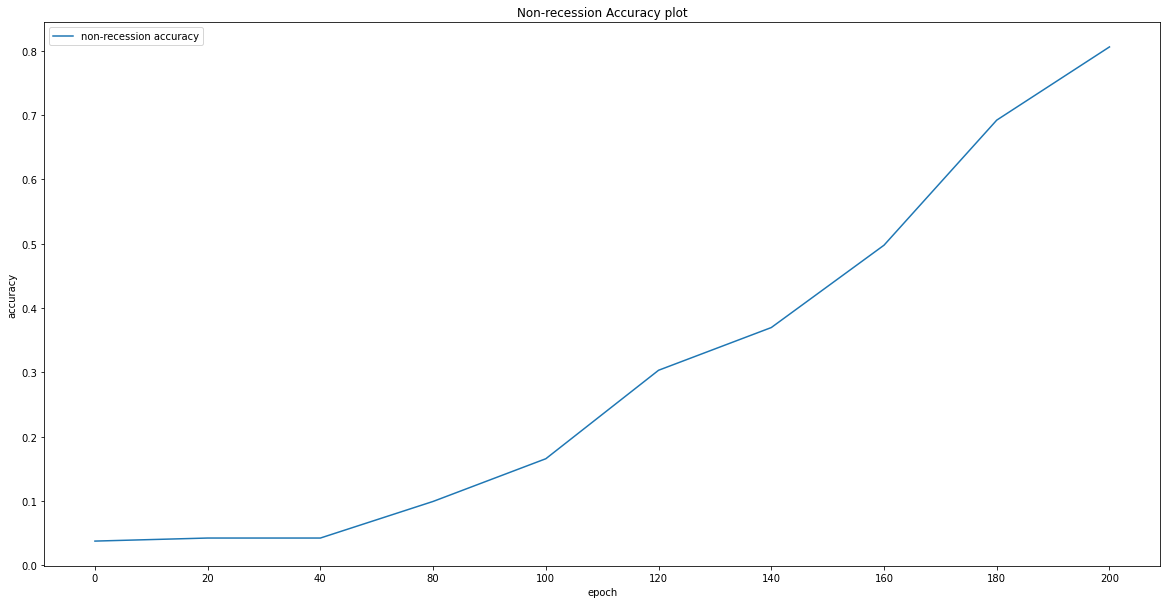

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

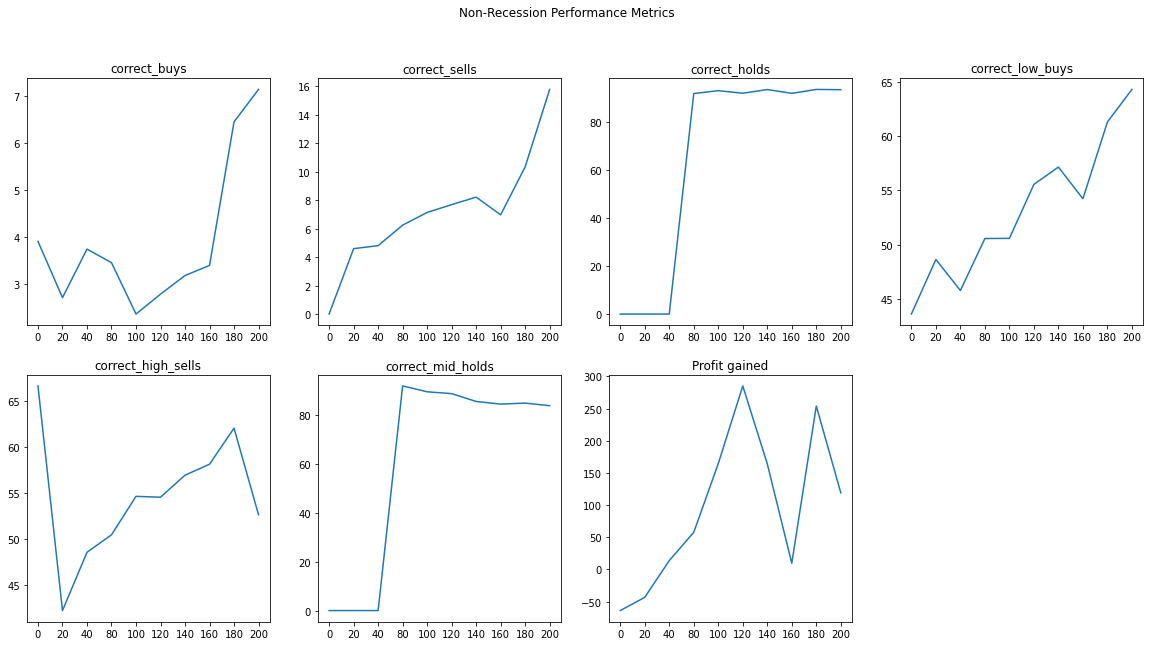

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

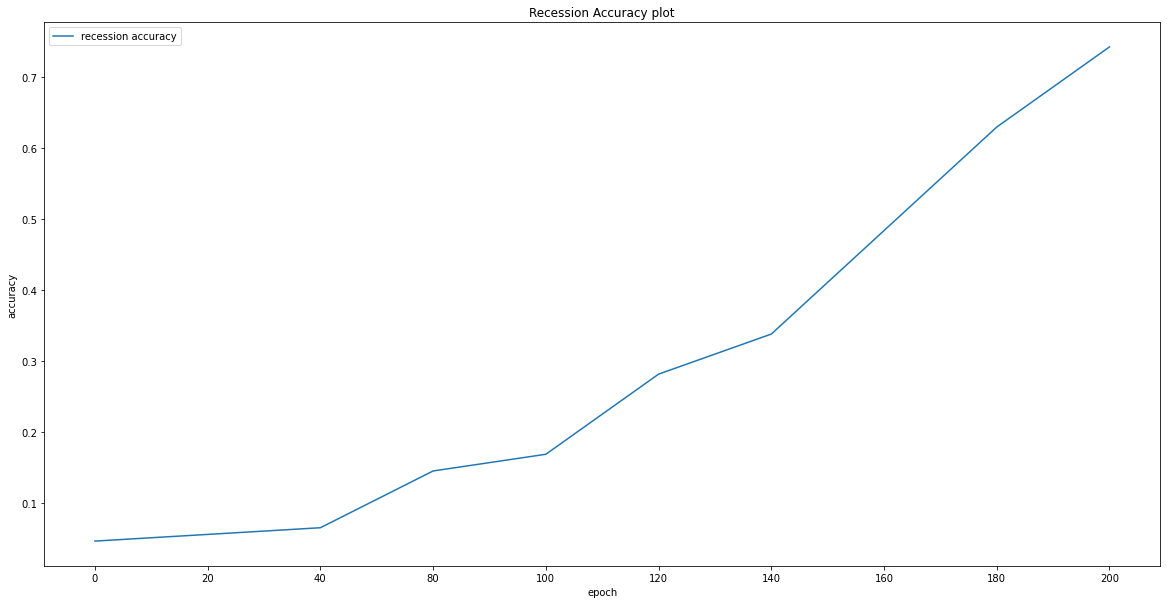

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

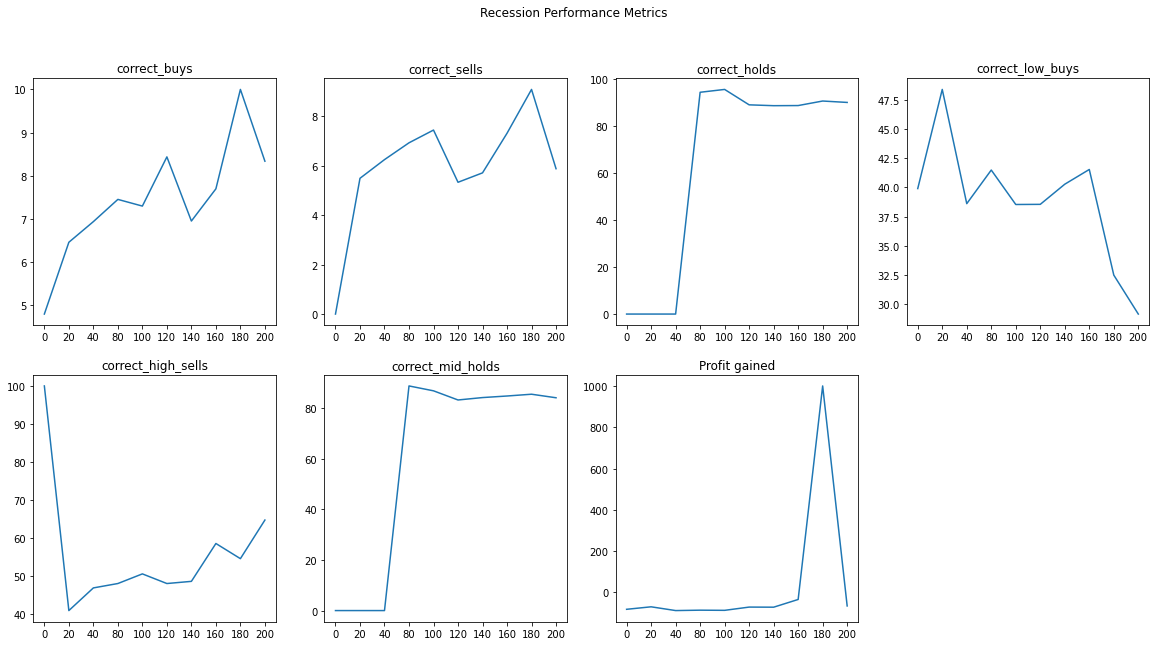

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### JP Morgan

In [83]:
nr_test_sets = ['JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-06   107.230003  109.628444 -81.910265 -1.924741e+09     2.0
2018-12-07   105.190002  108.945607 -76.923030 -1.951955e+09     2.0
2018-12-10   103.290001  108.075514 -95.904060 -1.971203e+09     2.0
2018-12-11   101.360001  107.042358 -84.717107 -1.994840e+09     2.0
2018-12-12   100.370003  106.015842 -91.991154 -2.011700e+09     2.0


In [84]:
r_test_sets = ['JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-06   133.059998  131.187618  -5.091646  270369900.0     2.0
2019-12-09   135.039993  131.780291 -10.292145  280540500.0     2.0
2019-12-10   134.410004  132.184862 -19.054168  272042300.0     2.0
2019-12-11   134.500000  132.541037 -17.802480  279575200.0     2.0
2019-12-12   134.179993  132.793184 -22.253207  270563300.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


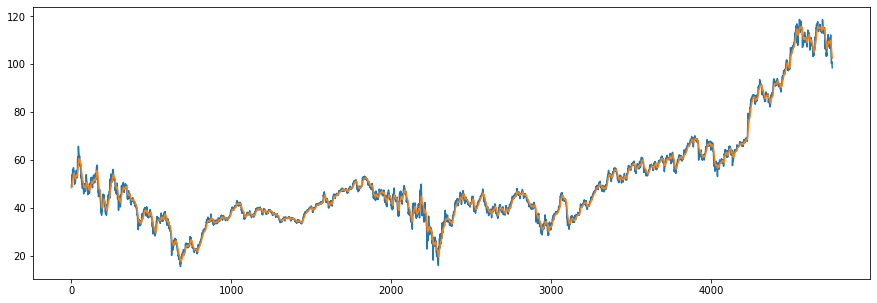

(4735, 64, 64, 1)

In [85]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]

    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

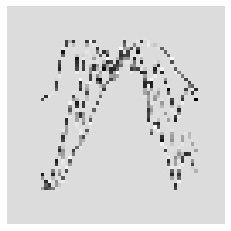

In [86]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [87]:
X = X/255

In [88]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [89]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [90]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [92]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JPM')]
    y = nr_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('JPM'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JPM')]
    y = r_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.699186991869919, 1: 7.427450980392157, 2: 0.36556649295502797}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 31ms/step - loss: 0.2401 - accuracy: 0.3382 - mse: 1.6637 - weighted_accuracy: 0.3157 - weighted_mse: 1.6897 - val_loss: 0.2088 - val_accuracy: 0.0433 - val_mse: 0.9512 - val_weighted_accuracy: 0.0433 - val_weighted_mse: 0.9512
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2044 - accuracy: 0.3501 - mse: 1.1828 - weighted_accuracy: 0.3353 - weighted_mse: 1.1870 - val_loss: 0.2036 - val_accuracy: 0.0454 - val_mse: 1.0421 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 1.0421
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2043 - accuracy: 0.3596 - mse: 1.1770 - weighted_accuracy: 0.3379 - weighted_mse: 1.1857 - val_loss: 0.2068 - val_accuracy: 0.0454 - val_mse: 1.0005 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 1.0005
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 10ms/step - loss: 0.2063 - accuracy: 0.0594 - mse: 0.9684 - weighted_accuracy: 0.0594 - weighted_mse: 0.9684


<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.20633801817893982
Test accuracy: 0.05936073139309883


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 9
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 12
actual sells but predicted hold: 0
actual holds but predicted buy: 18
actual holds but predicted sell: 179
actual predicted holds: 0
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 6.0%
Percentage holds correct: 0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 31.57894736842105%
Percentage high sells correct: 40.7035175879397%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at the moment: $0.07404328201354815


Price increase from previously bought: -5.939622575753544%
Share price: $0.6025046925238924
Shares owned at the moment: 0
Cash capital at the moment: $93.80630080264801


Share price: $0.502623409367

<ipython-input-92-f8274daa7903>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 0s 14ms/step - loss: 0.2006 - accuracy: 0.2978 - mse: 1.1955 - weighted_accuracy: 0.3702 - weighted_mse: 1.1865 - val_loss: 0.1995 - val_accuracy: 0.0612 - val_mse: 0.9997 - val_weighted_accuracy: 0.0612 - val_weighted_mse: 0.9997
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1996 - accuracy: 0.3440 - mse: 1.1903 - weighted_accuracy: 0.3517 - weighted_mse: 1.1944 - val_loss: 0.1863 - val_accuracy: 0.8289 - val_mse: 0.9874 - val_weighted_accuracy: 0.8289 - val_weighted_mse: 0.9874
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1991 - accuracy: 0.3601 - mse: 1.1731 - weighted_accuracy: 0.3536 - weighted_mse: 1.1760 - val_loss: 0.1964 - val_accuracy: 0.1214 - val_mse: 1.0182 - val_weighted_accuracy: 0.1214 - val_weighted_mse: 1.0182
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1990 - accuracy: 0.3416 - mse: 1.2156 - weighted_accuracy: 0.3738 - weighted_mse: 1.192

7/7 [==============================] - 0s 3ms/step - loss: 0.1888 - accuracy: 0.1507 - mse: 1.1236 - weighted_accuracy: 0.1507 - weighted_mse: 1.1236
Test loss: 0.1887635886669159
Test accuracy: 0.15068493783473969




<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 118
actual holds but predicted sell: 63
actual predicted holds: 16
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 88.88888888888889%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.75%
Percentage high sells correct: 48.611111111111114%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $1.0100000000000002
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999854


Price increase from previously bought: -1.1281719815541158%
Share price: $1.001351628009516
Shares owned at the moment: 0
Cash capital at the moment: $98.61040028118398


Share price: $1.001351628009516
Shares owned at the moment: 98


30/30 [==============================] - 0s 13ms/step - loss: 0.1820 - accuracy: 0.2112 - mse: 1.2734 - weighted_accuracy: 0.5155 - weighted_mse: 1.2317 - val_loss: 0.1961 - val_accuracy: 0.0750 - val_mse: 1.0560 - val_weighted_accuracy: 0.0750 - val_weighted_mse: 1.0560
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1787 - accuracy: 0.1814 - mse: 1.2626 - weighted_accuracy: 0.5329 - weighted_mse: 1.2398 - val_loss: 0.1982 - val_accuracy: 0.0676 - val_mse: 1.0821 - val_weighted_accuracy: 0.0676 - val_weighted_mse: 1.0821
Epoch 11/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1794 - accuracy: 0.1877 - mse: 1.2990 - weighted_accuracy: 0.5160 - weighted_mse: 1.2426 - val_loss: 0.1980 - val_accuracy: 0.0549 - val_mse: 1.1328 - val_weighted_accuracy: 0.0549 - val_weighted_mse: 1.1328
Epoch 12/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1791 - accuracy: 0.1734 - mse: 1.3106 - weighted_accuracy: 0.5315 - weighted_mse: 1.

7/7 [==============================] - 0s 2ms/step - loss: 0.1964 - accuracy: 0.1279 - mse: 1.1813 - weighted_accuracy: 0.1279 - weighted_mse: 1.1813
Test loss: 0.1963922530412674
Test accuracy: 0.1278538852930069


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 115
actual holds but predicted sell: 72
actual predicted holds: 10
Percentage buys correct: 7.086614173228346%
Percentage sells correct: 10.975609756097562%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.23809523809524%
Percentage high sells correct: 48.78048780487805%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from previously b

<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1697 - accuracy: 0.1637 - mse: 1.3765 - weighted_accuracy: 0.5717 - weighted_mse: 1.3128 - val_loss: 0.2015 - val_accuracy: 0.1151 - val_mse: 1.1807 - val_weighted_accuracy: 0.1151 - val_weighted_mse: 1.1807
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1706 - accuracy: 0.1663 - mse: 1.4030 - weighted_accuracy: 0.5406 - weighted_mse: 1.3332 - val_loss: 0.1984 - val_accuracy: 0.1024 - val_mse: 1.1601 - val_weighted_accuracy: 0.1024 - val_weighted_mse: 1.1601
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1682 - accuracy: 0.1737 - mse: 1.3405 - weighted_accuracy: 0.5695 - weighted_mse: 1.3006 - val_loss: 0.2020 - val_accuracy: 0.1003 - val_mse: 1.1631 - val_weighted_accuracy: 0.1003 - val_weighted_mse: 1.1631
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1676 - accuracy: 0.1679 - mse: 1.3827 - weighted_accuracy: 0.5699 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.2603 - mse: 1.3168 - weighted_accuracy: 0.2603 - weighted_mse: 1.3168
Test loss: 0.18982483446598053
Test accuracy: 0.2602739632129669




<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 97
actual holds but predicted sell: 60
actual predicted holds: 40
Percentage buys correct: 8.411214953271028%
Percentage sells correct: 11.594202898550725%
Percentage holds correct: 93.02325581395348%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 49.27536231884058%
Percentage mid holds correct: 83.72093023255815%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from previously bought: -9.229674779145402%
Share price: $0.9109666573342325
Shares owned at the moment: 0
Cash capital at the moment: $90.58176028873442


Share price: $0.8109157602043964
Shares owned at the moment: 111
C

30/30 [==============================] - 0s 10ms/step - loss: 0.1460 - accuracy: 0.3308 - mse: 1.5505 - weighted_accuracy: 0.6694 - weighted_mse: 1.5622 - val_loss: 0.1986 - val_accuracy: 0.2270 - val_mse: 1.3387 - val_weighted_accuracy: 0.2270 - val_weighted_mse: 1.3387
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1473 - accuracy: 0.3184 - mse: 1.5165 - weighted_accuracy: 0.6651 - weighted_mse: 1.5439 - val_loss: 0.1817 - val_accuracy: 0.3178 - val_mse: 1.3661 - val_weighted_accuracy: 0.3178 - val_weighted_mse: 1.3661
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1432 - accuracy: 0.3376 - mse: 1.5522 - weighted_accuracy: 0.6910 - weighted_mse: 1.5616 - val_loss: 0.1932 - val_accuracy: 0.2608 - val_mse: 1.3044 - val_weighted_accuracy: 0.2608 - val_weighted_mse: 1.3044
Epoch 10/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1455 - accuracy: 0.3136 - mse: 1.5323 - weighted_accuracy: 0.6689 - weighted_mse: 1.55

7/7 [==============================] - 0s 3ms/step - loss: 0.1814 - accuracy: 0.4018 - mse: 1.2515 - weighted_accuracy: 0.4018 - weighted_mse: 1.2515
Test loss: 0.18143980205059052
Test accuracy: 0.4018264710903168


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 78
actual holds but predicted sell: 44
actual predicted holds: 75
Percentage buys correct: 8.13953488372093%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 91.46341463414635%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.23529411764706%
Percentage high sells correct: 50.98039215686274%
Percentage mid holds correct: 81.70731707317073%


Capital: 100
Share price: $0.8109157602043964
Shares owned at the moment: 122
Cash capital at the moment: $0.7962150175150668


Price 

<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1368 - accuracy: 0.4633 - mse: 1.5794 - weighted_accuracy: 0.7068 - weighted_mse: 1.6891 - val_loss: 0.1935 - val_accuracy: 0.3041 - val_mse: 1.4496 - val_weighted_accuracy: 0.3041 - val_weighted_mse: 1.4496
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1339 - accuracy: 0.4034 - mse: 1.6361 - weighted_accuracy: 0.7037 - weighted_mse: 1.7085 - val_loss: 0.1788 - val_accuracy: 0.4245 - val_mse: 1.4949 - val_weighted_accuracy: 0.4245 - val_weighted_mse: 1.4949
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1326 - accuracy: 0.4345 - mse: 1.6243 - weighted_accuracy: 0.7206 - weighted_mse: 1.7262 - val_loss: 0.1845 - val_accuracy: 0.3664 - val_mse: 1.4677 - val_weighted_accuracy: 0.3664 - val_weighted_mse: 1.4677
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1350 - accuracy: 0.4406 - mse: 1.6301 - weighted_accuracy: 0.7171 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1567 - accuracy: 0.6027 - mse: 1.3723 - weighted_accuracy: 0.6027 - weighted_mse: 1.3723
Test loss: 0.15671907365322113
Test accuracy: 0.6027397513389587




<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 50
actual holds but predicted sell: 21
actual predicted holds: 126
Percentage buys correct: 7.2727272727272725%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 81.42857142857143%


Capital: 100
Share price: $0.8109157602043964
Shares owned at the moment: 122
Cash capital at the moment: $0.7962150175150668


Price increase from previously bought: -58.81291695872285%
Share price: $0.33491102705595166
Shares owned at the moment: 0
Cash capital at the moment: $41.542997668763896


Share price: $0.22502458949795834
Shares owned at the moment: 184
Cash capital at the m

Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1011 - accuracy: 0.6338 - mse: 1.8800 - weighted_accuracy: 0.8243 - weighted_mse: 2.3226 - val_loss: 0.1564 - val_accuracy: 0.5998 - val_mse: 1.6773 - val_weighted_accuracy: 0.5998 - val_weighted_mse: 1.6773
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1072 - accuracy: 0.6344 - mse: 1.9060 - weighted_accuracy: 0.8038 - weighted_mse: 2.1984 - val_loss: 0.1612 - val_accuracy: 0.5723 - val_mse: 1.5363 - val_weighted_accuracy: 0.5723 - val_weighted_mse: 1.5363
Epoch 18/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1001 - accuracy: 0.6505 - mse: 1.9541 - weighted_accuracy: 0.8174 - weighted_mse: 2.4341 - val_loss: 0.1455 - val_accuracy: 0.6431 - val_mse: 1.6967 - val_weighted_accuracy: 0.6431 - val_weighted_mse: 1.6967
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1027 - accuracy: 0.6402 - mse: 1.9843 - weighted_accuracy: 0.8037 - weighte

<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1017 - accuracy: 0.6502 - mse: 1.9269 - weighted_accuracy: 0.8037 - weighted_mse: 2.3548 - val_loss: 0.1543 - val_accuracy: 0.6040 - val_mse: 1.6168 - val_weighted_accuracy: 0.6040 - val_weighted_mse: 1.6168
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1007 - accuracy: 0.6631 - mse: 1.9388 - weighted_accuracy: 0.8182 - weighted_mse: 2.3841 - val_loss: 0.1393 - val_accuracy: 0.6695 - val_mse: 1.8656 - val_weighted_accuracy: 0.6695 - val_weighted_mse: 1.8656
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1011 - accuracy: 0.6370 - mse: 2.0170 - weighted_accuracy: 0.8007 - weighted_mse: 2.5158 - val_loss: 0.1437 - val_accuracy: 0.6484 - val_mse: 1.6003 - val_weighted_accuracy: 0.6484 - val_weighted_mse: 1.6003
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0972 - accuracy: 0.6626 - mse: 2.0330 - weighted_accuracy: 0.8197 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1158 - accuracy: 0.7808 - mse: 1.8254 - weighted_accuracy: 0.7808 - weighted_mse: 1.8254
Test loss: 0.11579523980617523
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 18
actual holds but predicted sell: 9
actual predicted holds: 170
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 0.0%
Percentage holds correct: 89.47368421052632%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.10526315789474%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at the moment: $0.07404328201354815


Price increase from previously bought: -68.

<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0895 - accuracy: 0.7120 - mse: 2.1443 - weighted_accuracy: 0.8231 - weighted_mse: 2.6875 - val_loss: 0.1306 - val_accuracy: 0.7075 - val_mse: 1.8054 - val_weighted_accuracy: 0.7075 - val_weighted_mse: 1.8054
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0856 - accuracy: 0.7128 - mse: 2.3493 - weighted_accuracy: 0.8440 - weighted_mse: 2.9919 - val_loss: 0.1230 - val_accuracy: 0.7413 - val_mse: 1.9136 - val_weighted_accuracy: 0.7413 - val_weighted_mse: 1.9136
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0808 - accuracy: 0.7262 - mse: 2.2796 - weighted_accuracy: 0.8582 - weighted_mse: 3.0627 - val_loss: 0.1158 - val_accuracy: 0.7782 - val_mse: 1.8504 - val_weighted_accuracy: 0.7782 - val_weighted_mse: 1.8504
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0849 - accuracy: 0.7175 - mse: 2.2033 - weighted_accuracy: 0.8478 - weighted




RUNNING EPOCHS 180 - 200





<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0675 - accuracy: 0.7856 - mse: 2.7532 - weighted_accuracy: 0.8896 - weighted_mse: 3.6350 - val_loss: 0.1202 - val_accuracy: 0.7666 - val_mse: 2.1775 - val_weighted_accuracy: 0.7666 - val_weighted_mse: 2.1775
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0676 - accuracy: 0.7769 - mse: 2.8394 - weighted_accuracy: 0.8825 - weighted_mse: 3.6715 - val_loss: 0.1176 - val_accuracy: 0.7719 - val_mse: 2.3027 - val_weighted_accuracy: 0.7719 - val_weighted_mse: 2.3027
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0700 - accuracy: 0.7848 - mse: 2.8168 - weighted_accuracy: 0.8818 - weighted_mse: 3.6218 - val_loss: 0.1107 - val_accuracy: 0.8015 - val_mse: 2.2002 - val_weighted_accuracy: 0.8015 - val_weighted_mse: 2.2002
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0634 - accuracy: 0.7872 - mse: 2.8486 - weighted_accuracy: 0.8863 - weighted_m

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 11
actual holds but predicted sell: 2
actual predicted holds: 184
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.32038834951456%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 60.0%
Percentage high sells correct: 0.0%
Percentage mid holds correct: 82.03883495145631%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at the moment: $0.07404328201354815


Price increase from previously bought: -68.9471096964033%
Share price: $0.19890960079779396
Shares owned at the moment: 0
Cash capital at the moment: $31.01860878772715


Share price: $0.3104917899591635
Shares owned at the moment: 99
Cash capital at the moment: $0.195390191

<ipython-input-92-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-92-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-92-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

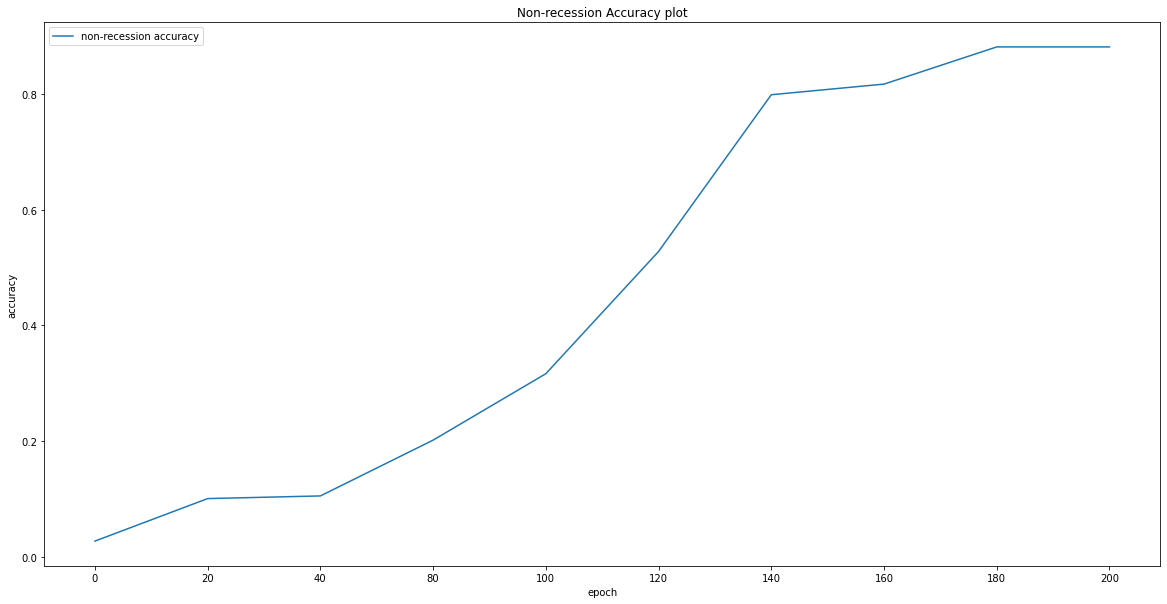

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

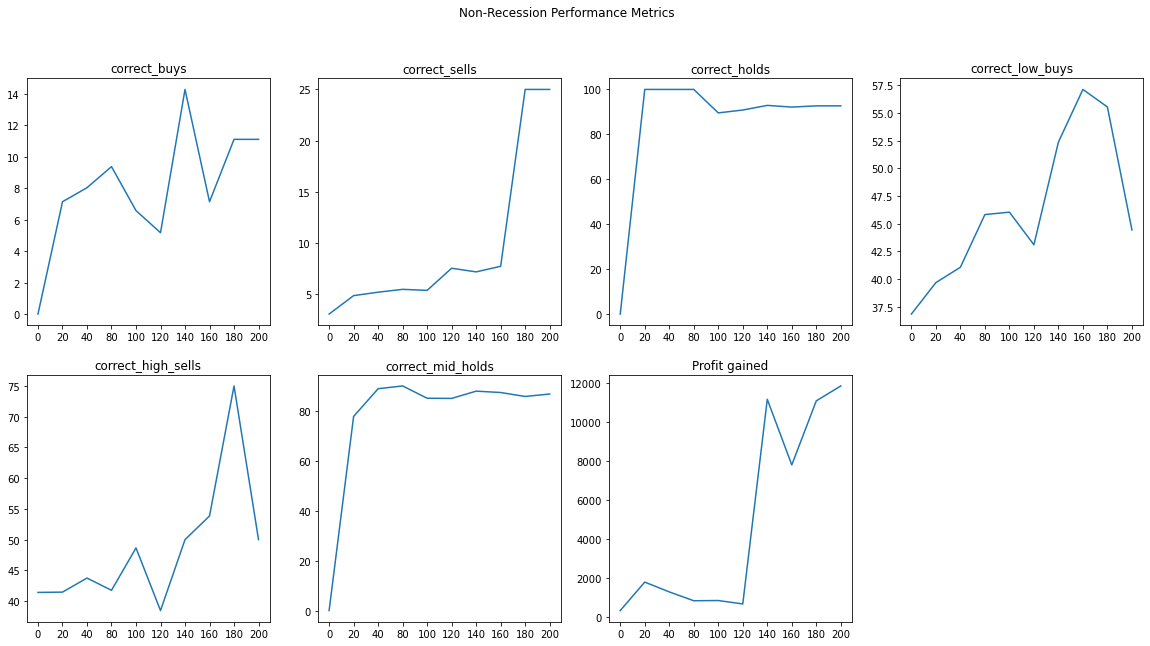

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

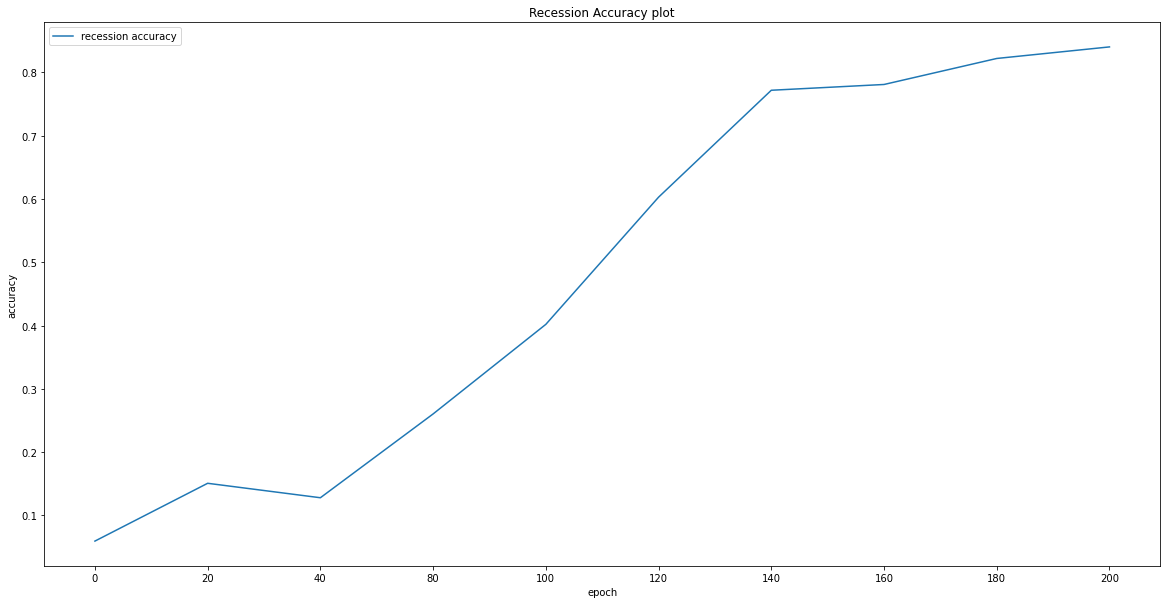

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

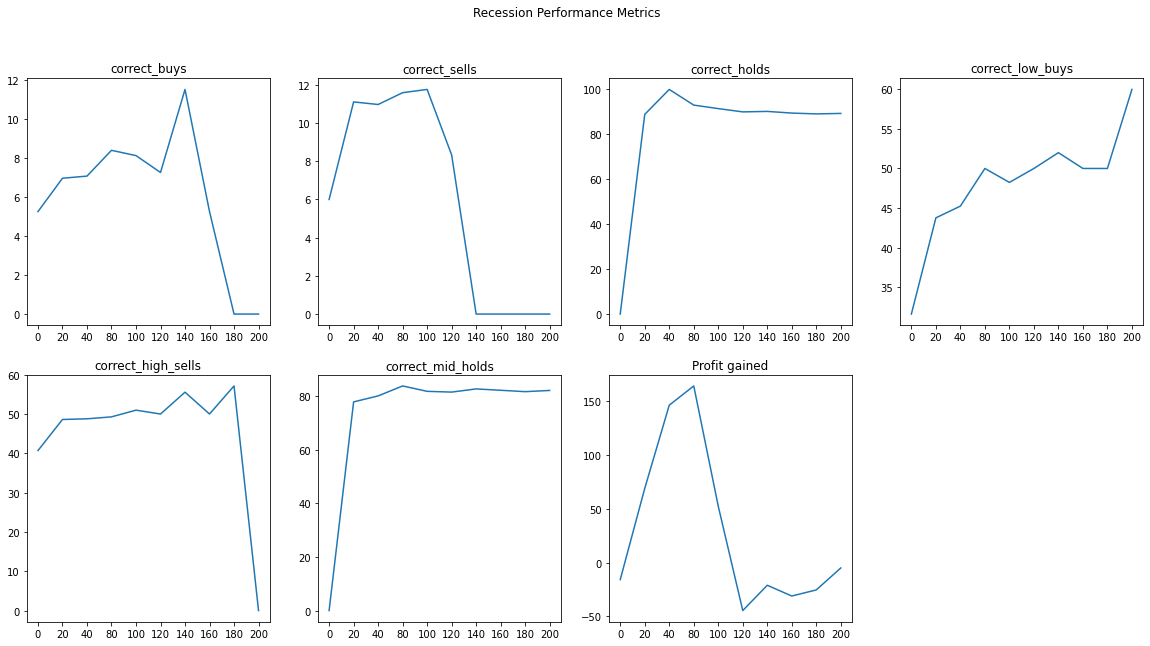

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### American Axle

In [70]:
nr_test_sets = ['AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-06        12.27  12.266266 -43.949026  234486200.0     2.0
2018-12-07        11.98  12.222225 -62.420426  231459100.0     2.0
2018-12-10        11.33  12.084959 -93.678180  229051600.0     2.0
2018-12-11        11.38  11.976504 -73.831760  231349000.0     2.0
2018-12-12        11.32  11.875503 -76.635518  229316700.0     2.0


In [71]:
r_test_sets = ['AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_25_price = []
    data_25_willr = []
    data_25_ema = []
    data_25_obv = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
            data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
            data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
            data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
            price_data.append(data_25_price_arr)
            willr_data.append(data_25_willr_arr)
            ema_data.append(data_25_ema_arr)
            obv_data.append(data_25_obv_arr)
            labels.append(i[-1])
            data_25_price = data_25_price[1:]
            data_25_willr = data_25_willr[1:]
            data_25_obv = data_25_obv[1:]
            data_25_ema = data_25_ema[1:]

        else:
            data_25_price.append([i[0]])
            data_25_ema.append([i[1]])
            data_25_willr.append([i[2]])
            data_25_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2019-12-06         9.49  9.751830 -78.151251 -15220600.0     2.0
2019-12-09        10.09  9.803856 -27.731074 -13947000.0     2.0
2019-12-10        10.02  9.837109 -33.613398 -14784200.0     2.0
2019-12-11        10.06  9.871400 -30.252058 -12899200.0     2.0
2019-12-12        10.53  9.972723  -7.801457 -10425400.0     0.0


### Training Data

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


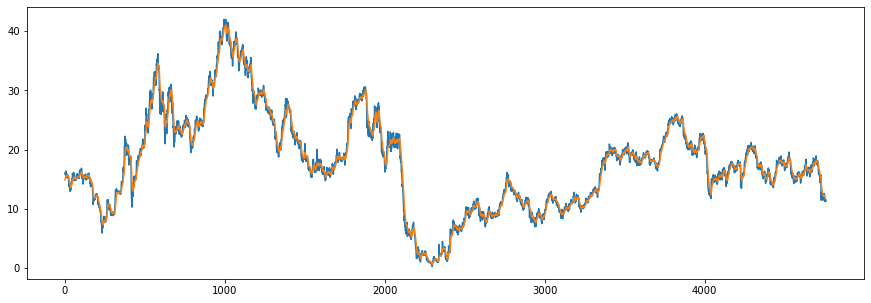

(4735, 64, 64, 1)

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/AXL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]

    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

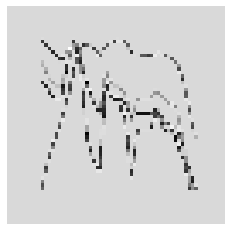

In [73]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [74]:
X = X/255

In [75]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [76]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [77]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [79]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('AXL')]
    y = nr_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('AXL'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('AXL')]
    y = r_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.256704980842912, 1: 7.298651252408478, 2: 0.36694759275404437}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2440 - accuracy: 0.4306 - mse: 1.6156 - weighted_accuracy: 0.3296 - weighted_mse: 1.7412 - val_loss: 0.1766 - val_accuracy: 0.9081 - val_mse: 0.9313 - val_weighted_accuracy: 0.9081 - val_weighted_mse: 0.9313
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2075 - accuracy: 0.4968 - mse: 1.1400 - weighted_accuracy: 0.3229 - weighted_mse: 1.1701 - val_loss: 0.1862 - val_accuracy: 0.9081 - val_mse: 0.8705 - val_weighted_accuracy: 0.9081 - val_weighted_mse: 0.8705
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2063 - accuracy: 0.5161 - mse: 1.1283 - weighted_accuracy: 0.3519 - weighted_mse: 1.1642 - val_loss: 0.1971 - val_accuracy: 0.8933 - val_mse: 0.7705 - val_weighted_accuracy: 0.8933 - val_weighted_mse: 0.7705
Epoch 4/20
30/30 [==============================] - 0s 9

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 10
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 1
actual holds but predicted sell: 192
actual predicted holds: 4
Percentage buys correct: 0.0%
Percentage sells correct: 5.164319248826291%
Percentage holds correct: 80.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 0.0%
Percentage high sells correct: 43.867924528301884%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.5126315607027336
Shares owned at the moment: 194
Cash capital at the moment: $0.2759882860347602


Price increase from previously bought: -4.881694215568222%
Share price: $0.48894737320923726
Shares owned at the moment: 0
Cash capital at the moment: $94.87092526501965




Capital at the end of test period: $94.87092526501965
profit gained: -5.12907473498035%


Capital at 

7/7 [==============================] - 0s 2ms/step - loss: 0.1882 - accuracy: 0.5799 - mse: 1.0060 - weighted_accuracy: 0.5799 - weighted_mse: 1.0060
Test loss: 0.1882222443819046
Test accuracy: 0.5799086689949036


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 4
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 3
actual holds but predicted sell: 72
actual predicted holds: 122
Percentage buys correct: 0.0%
Percentage sells correct: 6.172839506172839%
Percentage holds correct: 90.37037037037037%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 0.0%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 82.08955223880596%


Capital: 100
Share price: $0.5126315607027336
Shares owned at the moment: 194
Cash capital at the moment: $0.2759882860347602


Price increase from previously bou

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1956 - accuracy: 0.3244 - mse: 1.1826 - weighted_accuracy: 0.4001 - weighted_mse: 1.1792 - val_loss: 0.1915 - val_accuracy: 0.3812 - val_mse: 0.9743 - val_weighted_accuracy: 0.3812 - val_weighted_mse: 0.9743
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1949 - accuracy: 0.2888 - mse: 1.1797 - weighted_accuracy: 0.3980 - weighted_mse: 1.1728 - val_loss: 0.1940 - val_accuracy: 0.2608 - val_mse: 0.9584 - val_weighted_accuracy: 0.2608 - val_weighted_mse: 0.9584
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1934 - accuracy: 0.3105 - mse: 1.1778 - weighted_accuracy: 0.4278 - weighted_mse: 1.1732 - val_loss: 0.1970 - val_accuracy: 0.0908 - val_mse: 1.0272 - val_weighted_accuracy: 0.0908 - val_weighted_mse: 1.0272
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1931 - accuracy: 0.2907 - mse: 1.2200 - weighted_accuracy: 0.4024 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1906 - accuracy: 0.2877 - mse: 0.9649 - weighted_accuracy: 0.2877 - weighted_mse: 0.9649
Test loss: 0.19056478142738342
Test accuracy: 0.2876712381839752


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 66
actual holds but predicted sell: 80
actual predicted holds: 51
Percentage buys correct: 7.042253521126761%
Percentage sells correct: 7.865168539325842%
Percentage holds correct: 86.44067796610169%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 48.57142857142857%
Percentage high sells correct: 55.056179775280896%
Percentage mid holds correct: 79.66101694915254%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Pric

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1857 - accuracy: 0.2402 - mse: 1.2049 - weighted_accuracy: 0.4331 - weighted_mse: 1.1903 - val_loss: 0.1928 - val_accuracy: 0.1763 - val_mse: 1.0458 - val_weighted_accuracy: 0.1763 - val_weighted_mse: 1.0458
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1838 - accuracy: 0.2954 - mse: 1.2405 - weighted_accuracy: 0.4770 - weighted_mse: 1.2052 - val_loss: 0.1889 - val_accuracy: 0.2693 - val_mse: 1.0776 - val_weighted_accuracy: 0.2693 - val_weighted_mse: 1.0776
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1854 - accuracy: 0.2339 - mse: 1.1979 - weighted_accuracy: 0.4452 - weighted_mse: 1.1736 - val_loss: 0.1919 - val_accuracy: 0.1816 - val_mse: 1.0546 - val_weighted_accuracy: 0.1816 - val_weighted_mse: 1.0546
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1852 - accuracy: 0.2724 - mse: 1.2199 - weighted_accuracy: 0.4667 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.2009 - mse: 1.1491 - weighted_accuracy: 0.2009 - weighted_mse: 1.1491
Test loss: 0.19229960441589355
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 60
actual holds but predicted sell: 105
actual predicted holds: 32
Percentage buys correct: 6.25%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 82.05128205128206%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 54.310344827586206%
Percentage mid holds correct: 79.48717948717949%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Price increase f

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1677 - accuracy: 0.2661 - mse: 1.2503 - weighted_accuracy: 0.5555 - weighted_mse: 1.2315 - val_loss: 0.1888 - val_accuracy: 0.2619 - val_mse: 1.1500 - val_weighted_accuracy: 0.2619 - val_weighted_mse: 1.1500
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1652 - accuracy: 0.2664 - mse: 1.2696 - weighted_accuracy: 0.5684 - weighted_mse: 1.2533 - val_loss: 0.1943 - val_accuracy: 0.1932 - val_mse: 1.1304 - val_weighted_accuracy: 0.1932 - val_weighted_mse: 1.1304
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1611 - accuracy: 0.2856 - mse: 1.3042 - weighted_accuracy: 0.6103 - weighted_mse: 1.3115 - val_loss: 0.1882 - val_accuracy: 0.2777 - val_mse: 1.2230 - val_weighted_accuracy: 0.2777 - val_weighted_mse: 1.2230
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1627 - accuracy: 0.2672 - mse: 1.3209 - weighted_accuracy: 0.5797 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1786 - accuracy: 0.3744 - mse: 1.2665 - weighted_accuracy: 0.3744 - weighted_mse: 1.2665
Test loss: 0.17857465147972107
Test accuracy: 0.37442922592163086


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 46
actual holds but predicted sell: 78
actual predicted holds: 73
Percentage buys correct: 8.0%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 86.9047619047619%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 46.93877551020408%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 80.95238095238095%


Capital: 100
Share price: $0.7323683459689425
Shares owned at the moment: 136
Cash capital at the moment: $0.1239991868314263


Price increase from previously bo

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1427 - accuracy: 0.3735 - mse: 1.5106 - weighted_accuracy: 0.6790 - weighted_mse: 1.5095 - val_loss: 0.1827 - val_accuracy: 0.3738 - val_mse: 1.3575 - val_weighted_accuracy: 0.3738 - val_weighted_mse: 1.3575
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1403 - accuracy: 0.3786 - mse: 1.5788 - weighted_accuracy: 0.6863 - weighted_mse: 1.5735 - val_loss: 0.1823 - val_accuracy: 0.3738 - val_mse: 1.3892 - val_weighted_accuracy: 0.3738 - val_weighted_mse: 1.3892
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1435 - accuracy: 0.3949 - mse: 1.5299 - weighted_accuracy: 0.6741 - weighted_mse: 1.5050 - val_loss: 0.1786 - val_accuracy: 0.4044 - val_mse: 1.3693 - val_weighted_accuracy: 0.4044 - val_weighted_mse: 1.3693
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1413 - accuracy: 0.3804 - mse: 1.5434 - weighted_accuracy: 0.6797 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1664 - accuracy: 0.5251 - mse: 1.3938 - weighted_accuracy: 0.5251 - weighted_mse: 1.3938
Test loss: 0.16642288863658905
Test accuracy: 0.5251141786575317


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 33
actual holds but predicted sell: 56
actual predicted holds: 108
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 8.064516129032258%
Percentage holds correct: 88.52459016393442%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 51.42857142857143%
Percentage high sells correct: 62.903225806451616%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.7323683459689425
Shares owned at the moment: 136
Cash capital at the moment: $0.1239991868314263


Pric

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 120 - 140



Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1283 - accuracy: 0.5061 - mse: 1.6576 - weighted_accuracy: 0.7168 - weighted_mse: 1.7692 - val_loss: 0.1616 - val_accuracy: 0.5776 - val_mse: 1.4654 - val_weighted_accuracy: 0.5776 - val_weighted_mse: 1.4654
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1241 - accuracy: 0.4950 - mse: 1.7641 - weighted_accuracy: 0.7363 - weighted_mse: 1.8705 - val_loss: 0.1715 - val_accuracy: 0.5111 - val_mse: 1.4994 - val_weighted_accuracy: 0.5111 - val_weighted_mse: 1.4994
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1255 - accuracy: 0.5182 - mse: 1.7186 - weighted_accuracy: 0.7303 - weighted_mse: 1.8462 - val_loss: 0.1702 - val_accuracy: 0.5206 - val_mse: 1.4658 - val_weighted_accuracy: 0.5206 - val_weighted_mse: 1.4658
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1246 - accuracy: 0.4952 - mse: 1.6937 - weigh

7/7 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.5982 - mse: 1.5226 - weighted_accuracy: 0.5982 - weighted_mse: 1.5226
Test loss: 0.15920890867710114
Test accuracy: 0.5981734991073608


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 35
actual holds but predicted sell: 38
actual predicted holds: 124
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 90.51094890510949%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 51.282051282051285%
Percentage high sells correct: 58.13953488372093%
Percentage mid holds correct: 83.82352941176471%


Capital: 100
Share price: $0.7323683459689425
Shares owned at the moment: 136
Cash capital at the moment: $0.1239991868314263


Pric

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1142 - accuracy: 0.5821 - mse: 1.8780 - weighted_accuracy: 0.7574 - weighted_mse: 2.0918 - val_loss: 0.1539 - val_accuracy: 0.6304 - val_mse: 1.6085 - val_weighted_accuracy: 0.6304 - val_weighted_mse: 1.6085
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1091 - accuracy: 0.5855 - mse: 1.9424 - weighted_accuracy: 0.7732 - weighted_mse: 2.2187 - val_loss: 0.1545 - val_accuracy: 0.6220 - val_mse: 1.6134 - val_weighted_accuracy: 0.6220 - val_weighted_mse: 1.6134
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1113 - accuracy: 0.5964 - mse: 1.9658 - weighted_accuracy: 0.7736 - weighted_mse: 2.2432 - val_loss: 0.1456 - val_accuracy: 0.6917 - val_mse: 1.5104 - val_weighted_accuracy: 0.6917 - val_weighted_mse: 1.5104
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1126 - accuracy: 0.5895 - mse: 1.8611 - weighted_accuracy: 0.7674 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1416 - accuracy: 0.6621 - mse: 1.6681 - weighted_accuracy: 0.6621 - weighted_mse: 1.6681
Test loss: 0.1415625512599945
Test accuracy: 0.6621004343032837


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 26
actual holds but predicted sell: 31
actual predicted holds: 140
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 8.571428571428571%
Percentage holds correct: 89.74358974358974%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.57142857142857%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $0.6231578944891774
Shares owned at the moment: 160
Cash capital at the moment: $0.020547408156375013


Pri

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1015 - accuracy: 0.6383 - mse: 2.1606 - weighted_accuracy: 0.7853 - weighted_mse: 2.6434 - val_loss: 0.1327 - val_accuracy: 0.7413 - val_mse: 1.7407 - val_weighted_accuracy: 0.7413 - val_weighted_mse: 1.7407
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1014 - accuracy: 0.6265 - mse: 2.1945 - weighted_accuracy: 0.7864 - weighted_mse: 2.6846 - val_loss: 0.1328 - val_accuracy: 0.7402 - val_mse: 1.7427 - val_weighted_accuracy: 0.7402 - val_weighted_mse: 1.7427
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1004 - accuracy: 0.6584 - mse: 2.1497 - weighted_accuracy: 0.7945 - weighted_mse: 2.6125 - val_loss: 0.1310 - val_accuracy: 0.7518 - val_mse: 1.7513 - val_weighted_accuracy: 0.7518 - val_weighted_mse: 1.7513
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0962 - accuracy: 0.6494 - mse: 2.2753 - weighted_accuracy: 0.8149 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.7854 - mse: 1.7187 - weighted_accuracy: 0.7854 - weighted_mse: 1.7187
Test loss: 0.12182430177927017
Test accuracy: 0.7853881120681763


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 18
actual holds but predicted sell: 11
actual predicted holds: 168
Percentage buys correct: 10.0%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 90.3225806451613%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 60.0%
Percentage high sells correct: 76.92307692307692%
Percentage mid holds correct: 84.32432432432432%


Capital: 100
Share price: $0.6231578944891774
Shares owned at the moment: 160
Cash capital at the moment: $0.020547408156375013


Price increase from previousl

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0903 - accuracy: 0.6917 - mse: 2.4260 - weighted_accuracy: 0.8067 - weighted_mse: 3.0987 - val_loss: 0.1256 - val_accuracy: 0.7666 - val_mse: 1.8781 - val_weighted_accuracy: 0.7666 - val_weighted_mse: 1.8781
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0865 - accuracy: 0.6679 - mse: 2.4473 - weighted_accuracy: 0.8181 - weighted_mse: 3.3101 - val_loss: 0.1201 - val_accuracy: 0.7772 - val_mse: 1.9808 - val_weighted_accuracy: 0.7772 - val_weighted_mse: 1.9808
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0906 - accuracy: 0.6998 - mse: 2.3912 - weighted_accuracy: 0.8079 - weighted_mse: 3.0472 - val_loss: 0.1281 - val_accuracy: 0.7624 - val_mse: 1.7863 - val_weighted_accuracy: 0.7624 - val_weighted_mse: 1.7863
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0935 - accuracy: 0.6856 - mse: 2.3718 - weighted_accuracy: 0.7899 - weighted_m

7/7 [==============================] - 0s 2ms/step - loss: 0.1138 - accuracy: 0.8219 - mse: 1.9239 - weighted_accuracy: 0.8219 - weighted_mse: 1.9239
Test loss: 0.11377343535423279
Test accuracy: 0.8219178318977356


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 10
actual holds but predicted sell: 9
actual predicted holds: 178
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 10.0%
Percentage holds correct: 89.8989898989899%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 80.0%
Percentage mid holds correct: 84.26395939086295%


Capital: 100
Share price: $0.6231578944891774
Shares owned at the moment: 160
Cash capital at the moment: $0.020547408156375013


Price increase from previousl

<ipython-input-79-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-79-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-79-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

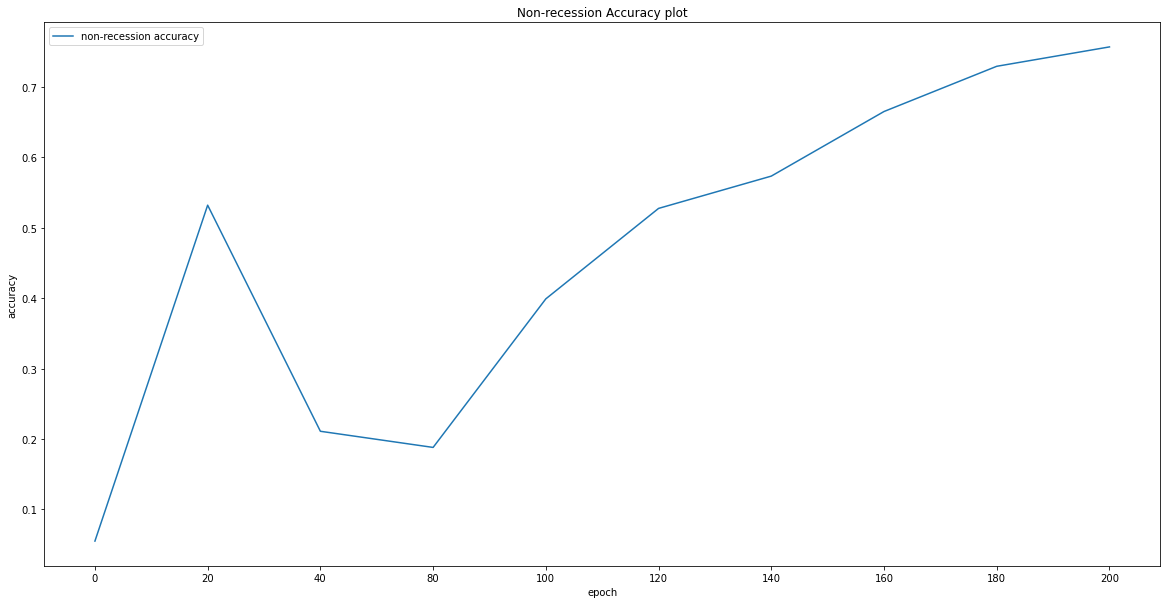

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

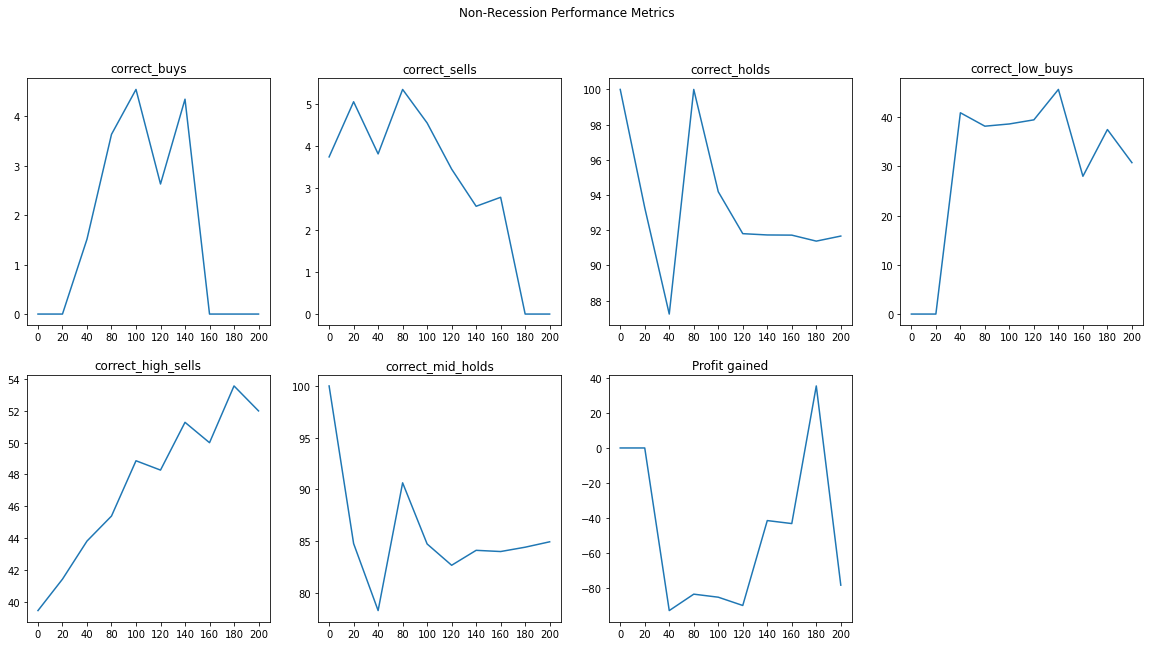

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

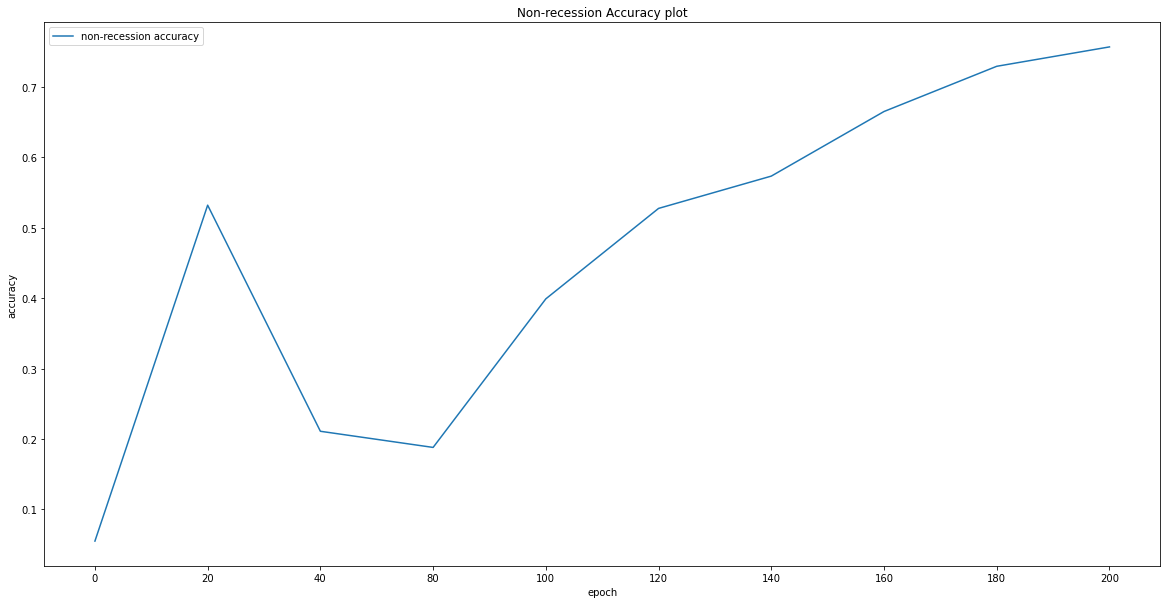

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

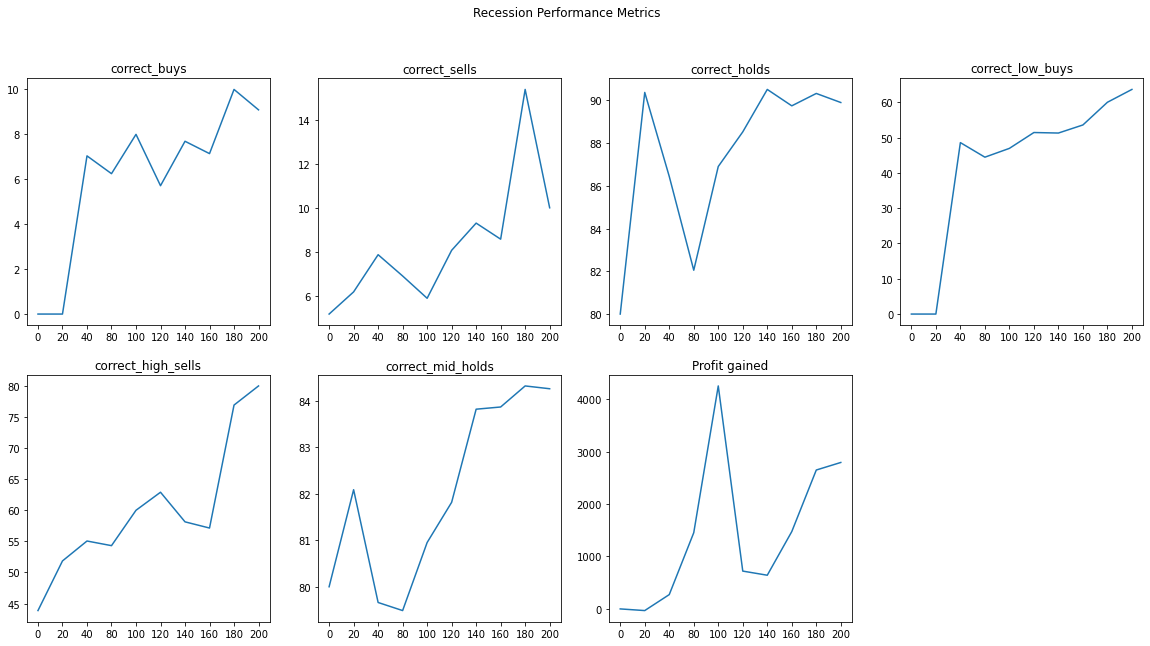

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")